In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special, interpolate
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

import powerlaw

In [2]:
df = pd.read_pickle('../data/df.pickle')
df.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [3]:
df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_20200601_20201116 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-17")].dropna()
df_20201117_20201216 = df[(df["started_at"] >= "2020-11-17") & (df["started_at"] < "2020-12-17")].dropna()
df_20201217_20201231 = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-01-01")].dropna()
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] < "2022-01-01")].dropna()
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] < "2023-01-01")].dropna()
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] < "2023-10-01")].dropna()
df_2020 = df[(df["started_at"] >= "2020-01-01") & (df["started_at"] < "2021-01-01")].dropna()

In [4]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []
    distance_list = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        # distance_listに平均距離を追加
        distance_list.append(df_tmp['distance'].mean())

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp, distance_list


In [5]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [6]:
node_lockdown, edge_lockdown, timestamp_lockdown, distance_lockdown = getNetworkAnalysis(df_lockdown)
node_20200601_20201116, edge_20200601_20201116, timestamp_20200601_20201116, distance_20200601_20201116 = getNetworkAnalysis(df_20200601_20201116)
node_20201117_20201216, edge_20201117_20201216, timestamp_20201117_20201216, distance_20201117_20201216 = getNetworkAnalysis(df_20201117_20201216)
node_20201217_20201231, edge_20201217_20201231, timestamp_20201217_20201231, distance_20201217_20201231 = getNetworkAnalysis(df_20201217_20201231)
node_2021, edge_2021, timestamp_2021, distance_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022, distance_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023, distance_2023 = getNetworkAnalysis(df_2023)
node_2020, edge_2020, timestamp_2020, distance_2020 = getNetworkAnalysis(df_2020)
# node_normal, edge_normal, timestamp_normal, distance_normal = getNetworkAnalysis(df_2020_normal)

In [7]:
kappa_lockdown = []
kappa_20200601_20201116 = []
kappa_20201117_20201216 = []
kappa_20201217_20201231 = []
kappa_2020 = []
kappa_2021 = []
kappa_2022 = []
kappa_2023 = []

In [9]:
alpha_lockdown, beta_lockdown = 0.086, 1.257
alpha_after_lockdown, beta_after_lockdown = 0.085, 5.735
alpha_stayhome, beta_stayhome = 0.085, 1.626
alpha_after_stayhome, beta_after_stayhome = 0.094, 3.621
alpha_2020, beta_2020 = 0.075, 0.795 
alpha_2021, beta_2021 = 0.087, 2.238
alpha_2022, beta_2022 = 0.118, 8.603
alpha_2023, beta_2023 = 0.119, 7.9

Np = 1652

## 全体活動量と平均移動距離の分析

In [11]:
node_lockdown, edge_lockdown, timestamp_lockdown, distance_lockdown = getNetworkAnalysis(df_lockdown)
node_after_lockdown, edge_after_lockdown, timestamp_after_lockdown, distance_after_lockdown = getNetworkAnalysis(df_20200601_20201116)
node_stayhome, edge_stayhome, timestamp_stayhome, distance_stayhome = getNetworkAnalysis(df_20201117_20201216)
node_after_stayhome, edge_after_stayhome, timestamp_after_stayhome, distance_after_stayhome = getNetworkAnalysis(df_20201217_20201231)
node_2020, edge_2020, timestamp_2020, distance_2020 = getNetworkAnalysis(df_2020)
node_2021, edge_2021, timestamp_2021, distance_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022, distance_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023, distance_2023 = getNetworkAnalysis(df_2023)

In [12]:
kappa_lockdown = []
for i in range(len(edge_lockdown)):
    alpha, beta = alpha_lockdown, beta_lockdown
    kappa_lockdown.append(kappa(edge_lockdown[i], Np))

In [13]:
kappa_after_lockdown = []
for i in range(len(edge_after_lockdown)):
    alpha, beta = alpha_after_lockdown, beta_after_lockdown
    kappa_after_lockdown.append(kappa(edge_after_lockdown[i], Np))

In [14]:
kappa_stayhome = []
for i in range(len(edge_stayhome)):
    alpha, beta = alpha_stayhome, beta_stayhome
    kappa_stayhome.append(kappa(edge_stayhome[i], Np))

In [15]:
kappa_after_stayhome = []
for i in range(len(edge_after_stayhome)):
    alpha, beta = alpha_after_stayhome, beta_after_stayhome
    kappa_after_stayhome.append(kappa(edge_after_stayhome[i], Np))

In [16]:
kappa_2020 = []
for i in range(len(edge_2020)):
    alpha, beta = alpha_2020, beta_2020
    kappa_2020.append(kappa(edge_2020[i], Np=Np))

In [17]:
kappa_2021 = []
for i in range(len(edge_2021)):
    alpha, beta = alpha_2021, beta_2021
    kappa_2021.append(kappa(edge_2021[i],Np=Np))

In [18]:
kappa_2022 = []
for i in range(len(edge_2022)):
    alpha, beta = alpha_2022, beta_2022
    kappa_2022.append(kappa(edge_2022[i],Np=Np))

In [19]:
kappa_2023 = []
for i in range(len(edge_2023)):
    alpha, beta = alpha_2023, beta_2023
    kappa_2023.append(kappa(edge_2023[i],Np=Np))

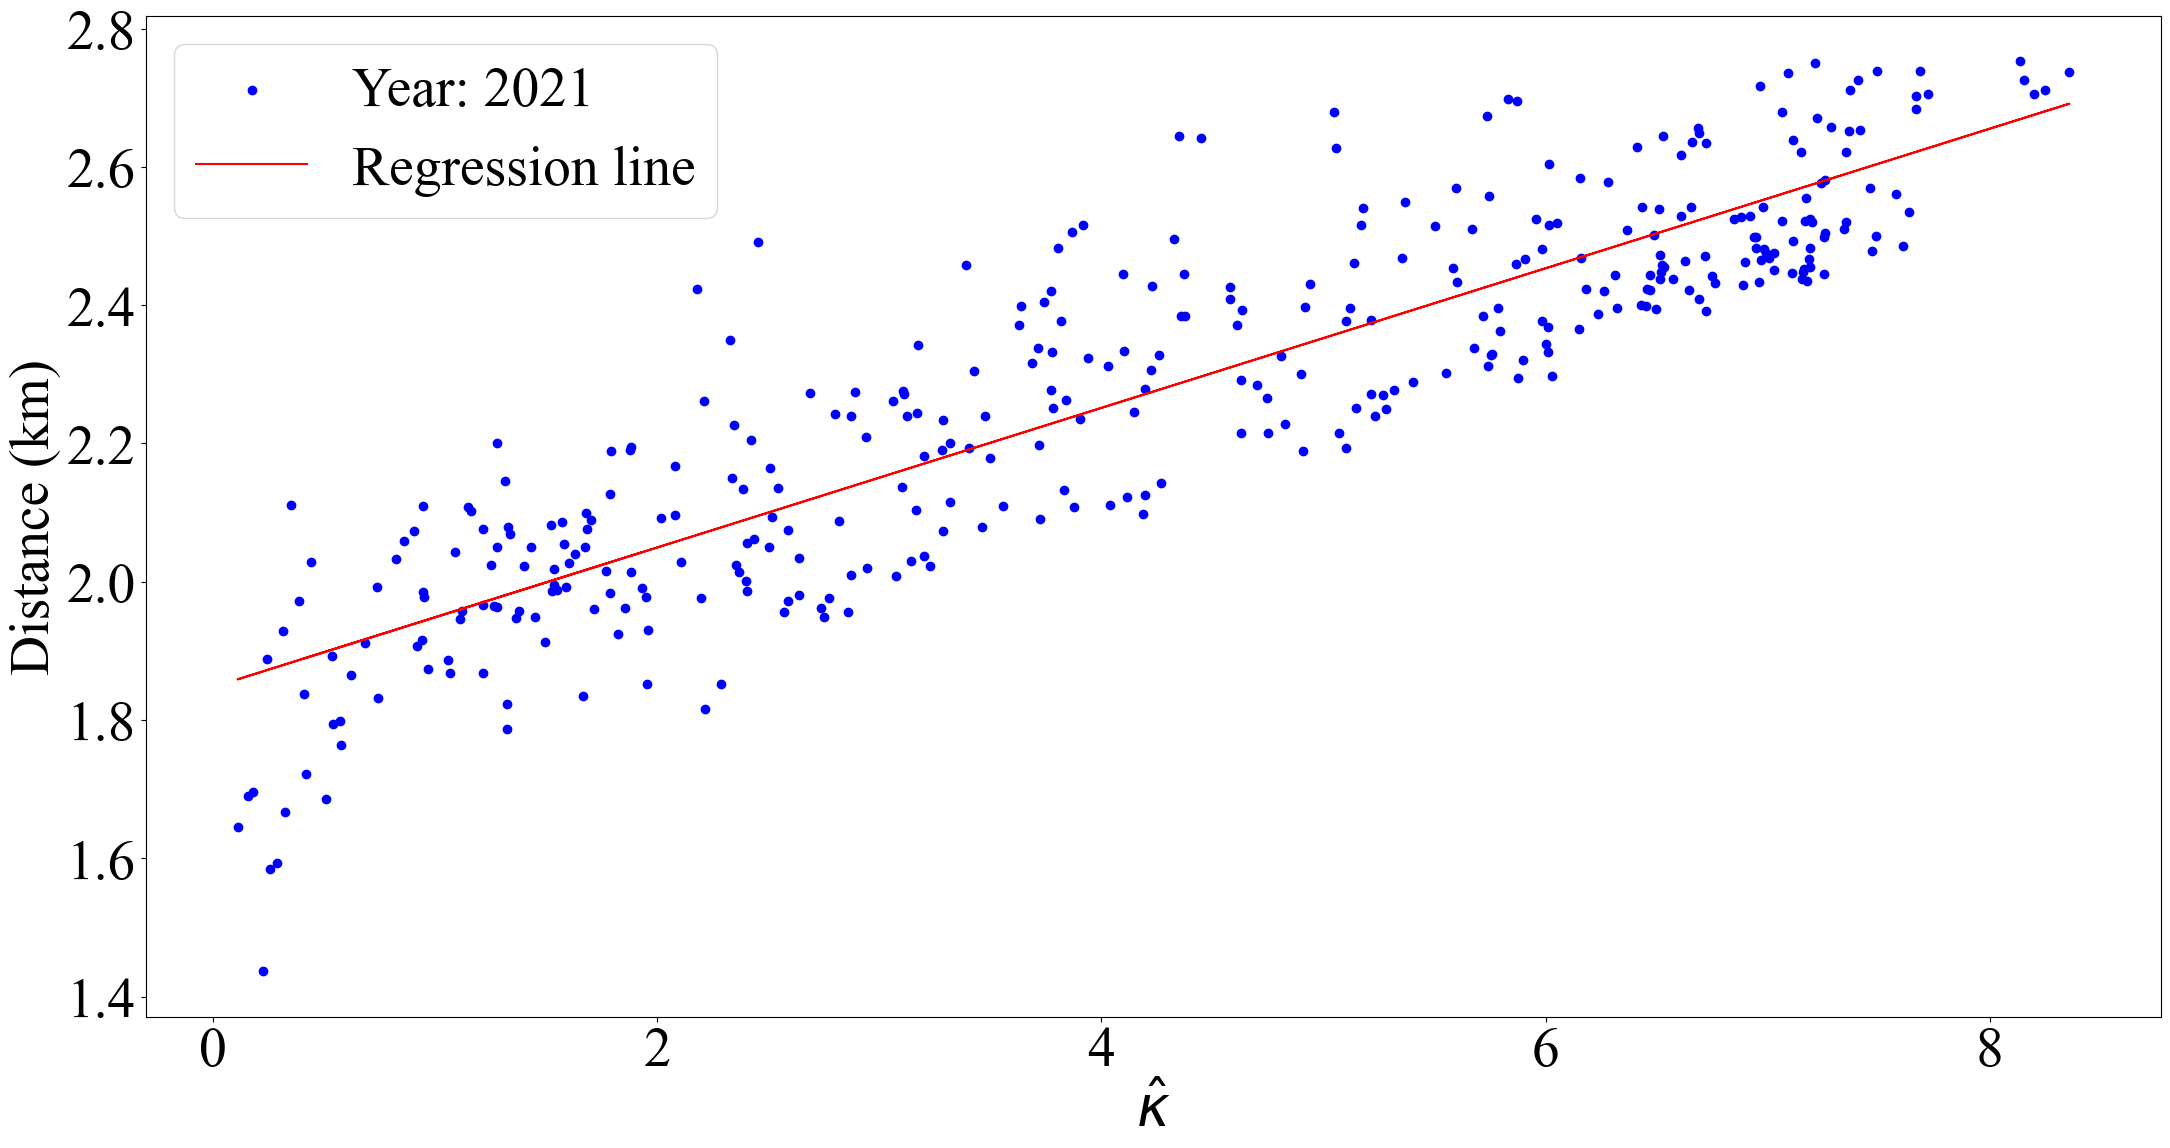

In [69]:
# 2021年のkappaと距離の関係
# olsを用いて回帰分析を行う
kappa_distance_2021_df = pd.DataFrame({"kappa": kappa_2021, "distance": distance_2021})
# kappa_distance.head()

model = smf.ols("distance ~ kappa", data=kappa_distance_2021_df)
result = model.fit()

plt.figure(figsize=(26, 13))
plt.rcParams["font.size"] = 30
plt.rcParams["font.family"] = "Times New Roman"

plt.scatter(kappa_2021, distance_2021, label="Year: 2021", color="blue")
plt.plot(kappa_2021, result.fittedvalues, color="red", label="Regression line")

# 右下に回帰式を表示
# plt.text(0.7, 0.1, r"y = 0.101$\hat{\kappa}$ + 1.848", transform=plt.gca().transAxes, fontsize=40)
# plt.text(0.7, 0.1, r"y = 0.101$\hat{\kappa}$ + 1.848", transform=plt.gca().transAxes, fontsize=40)

plt.xlabel(r"$\hat{\kappa}$", fontsize=40)
plt.ylabel("Distance (km)", fontsize=40)
plt.tick_params(labelsize=40)
plt.legend(prop={"size": 40})
plt.savefig("../fig/cssj/kappa_distance_2021.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

In [70]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     1367.
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          3.85e-125
Time:                        21:24:08   Log-Likelihood:                 256.25
No. Observations:                 365   AIC:                            -508.5
Df Residuals:                     363   BIC:                            -500.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8477      0.013    140.705      0.0

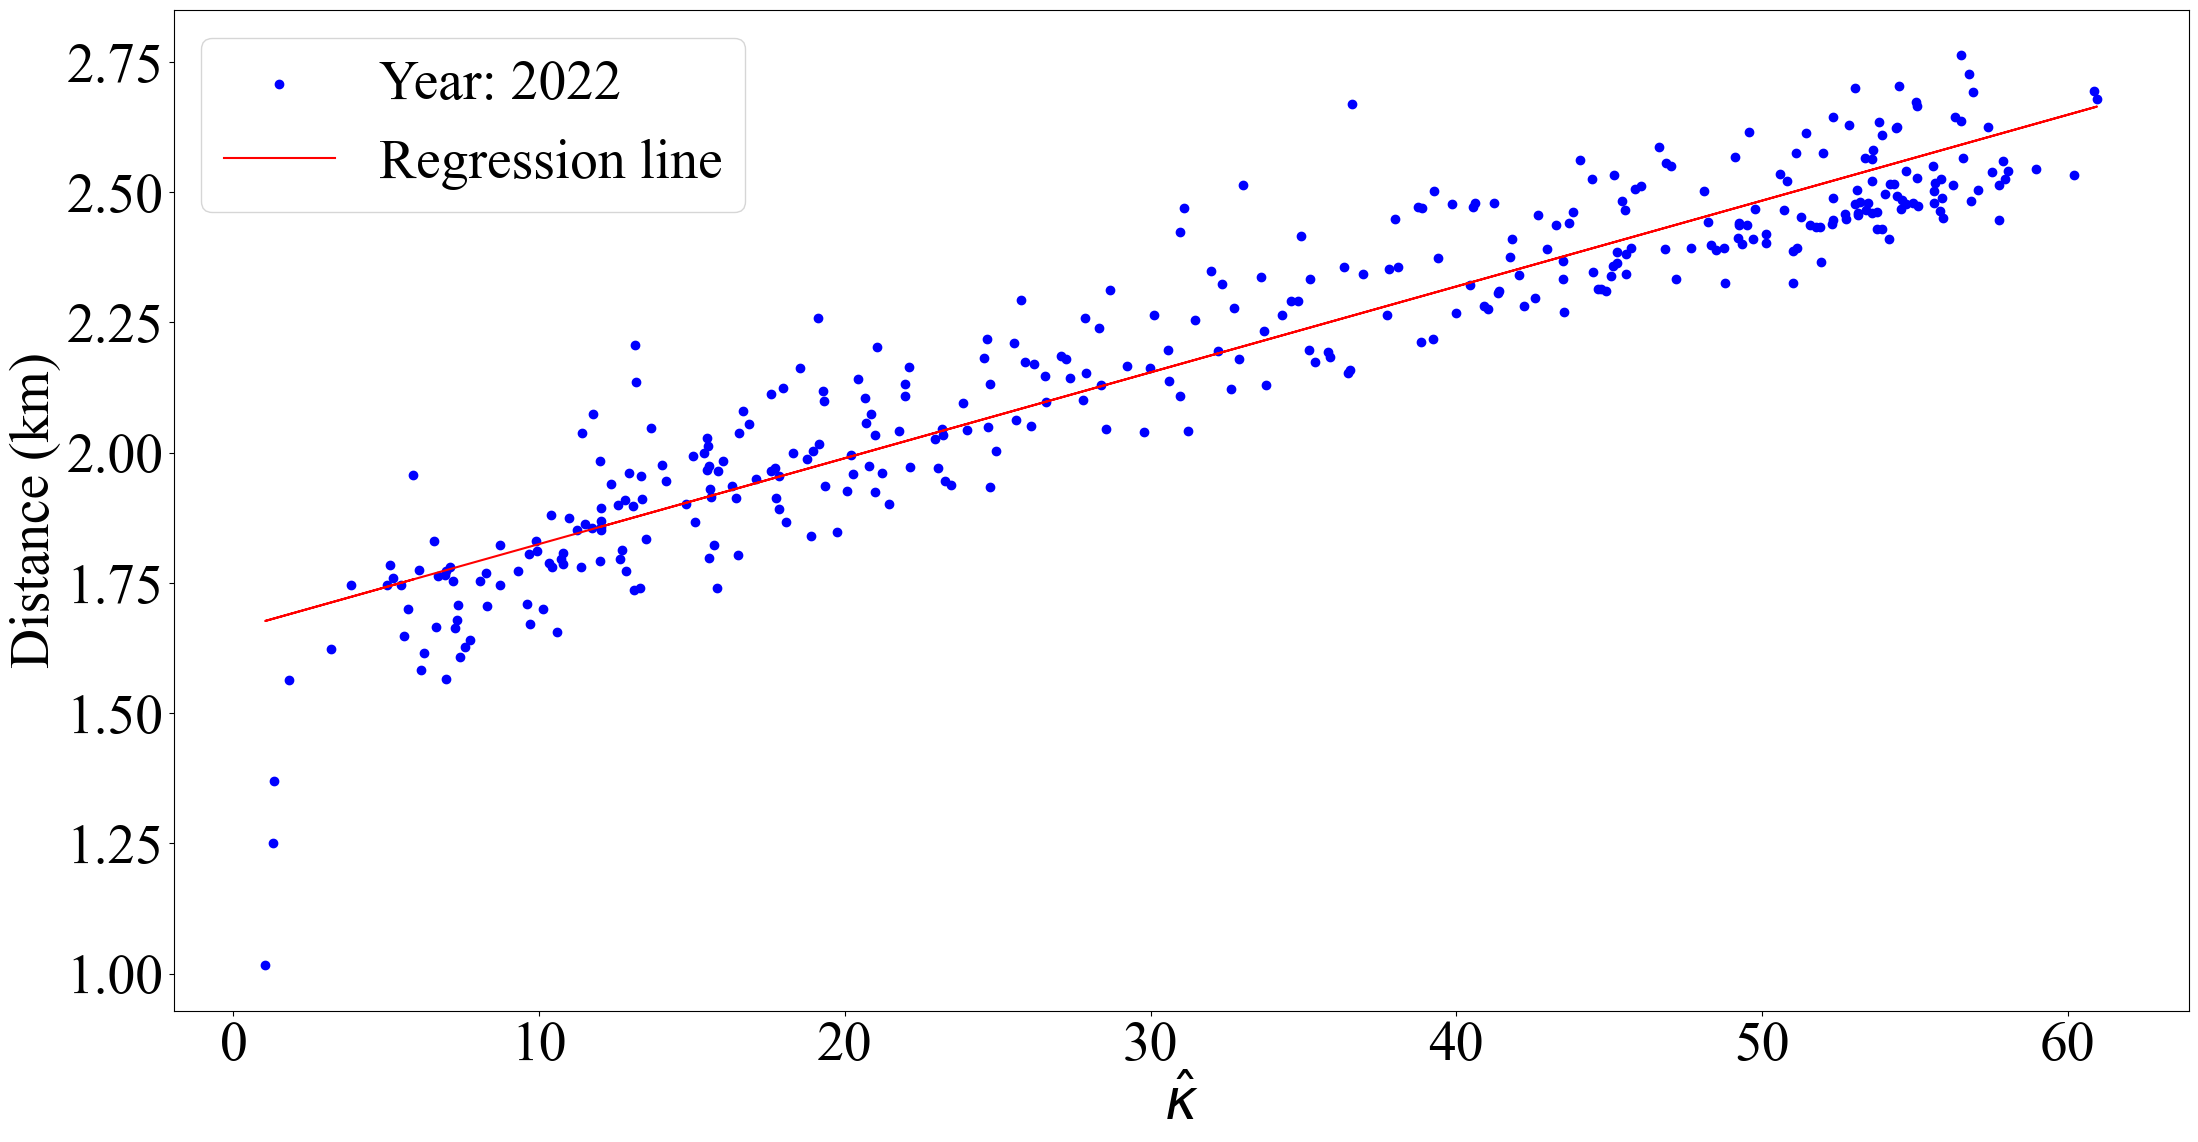

In [75]:
# 2022年のkappaと距離の関係
# olsを用いて回帰分析を行う
kappa_distance_2022_df = pd.DataFrame({"kappa": kappa_2022, "distance": distance_2022})

# kappa_distance_2022_dfのうち、10km以上のデータの行を削除
kappa_distance_2022_df = kappa_distance_2022_df[kappa_distance_2022_df["distance"] < 10]
# kappa_distance.head()

model = smf.ols("distance ~ kappa", data=kappa_distance_2022_df)
result = model.fit()

plt.figure(figsize=(26, 13))
plt.rcParams["font.size"] = 30
plt.rcParams["font.family"] = "Times New Roman"

plt.scatter(kappa_distance_2022_df["kappa"], kappa_distance_2022_df["distance"], label="Year: 2022", color="blue")
plt.plot(kappa_distance_2022_df["kappa"], result.fittedvalues, color="red", label="Regression line")
# plt.text(0.2, 0.1, f"y = {result.params[1]:.3f} + {result.params[0]:.3f}", transform=plt.gca().transAxes, fontsize=30)

plt.xlabel(r"$\hat{\kappa}$", fontsize=40)
plt.ylabel("Distance (km)", fontsize=40)
plt.tick_params(labelsize=40)
plt.legend(prop={"size": 40})
plt.savefig("../fig/cssj/kappa_distance_2022.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

In [76]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     2551.
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          5.44e-166
Time:                        21:29:40   Log-Likelihood:                 293.22
No. Observations:                 364   AIC:                            -582.4
Df Residuals:                     362   BIC:                            -574.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6597      0.012    139.425      0.0

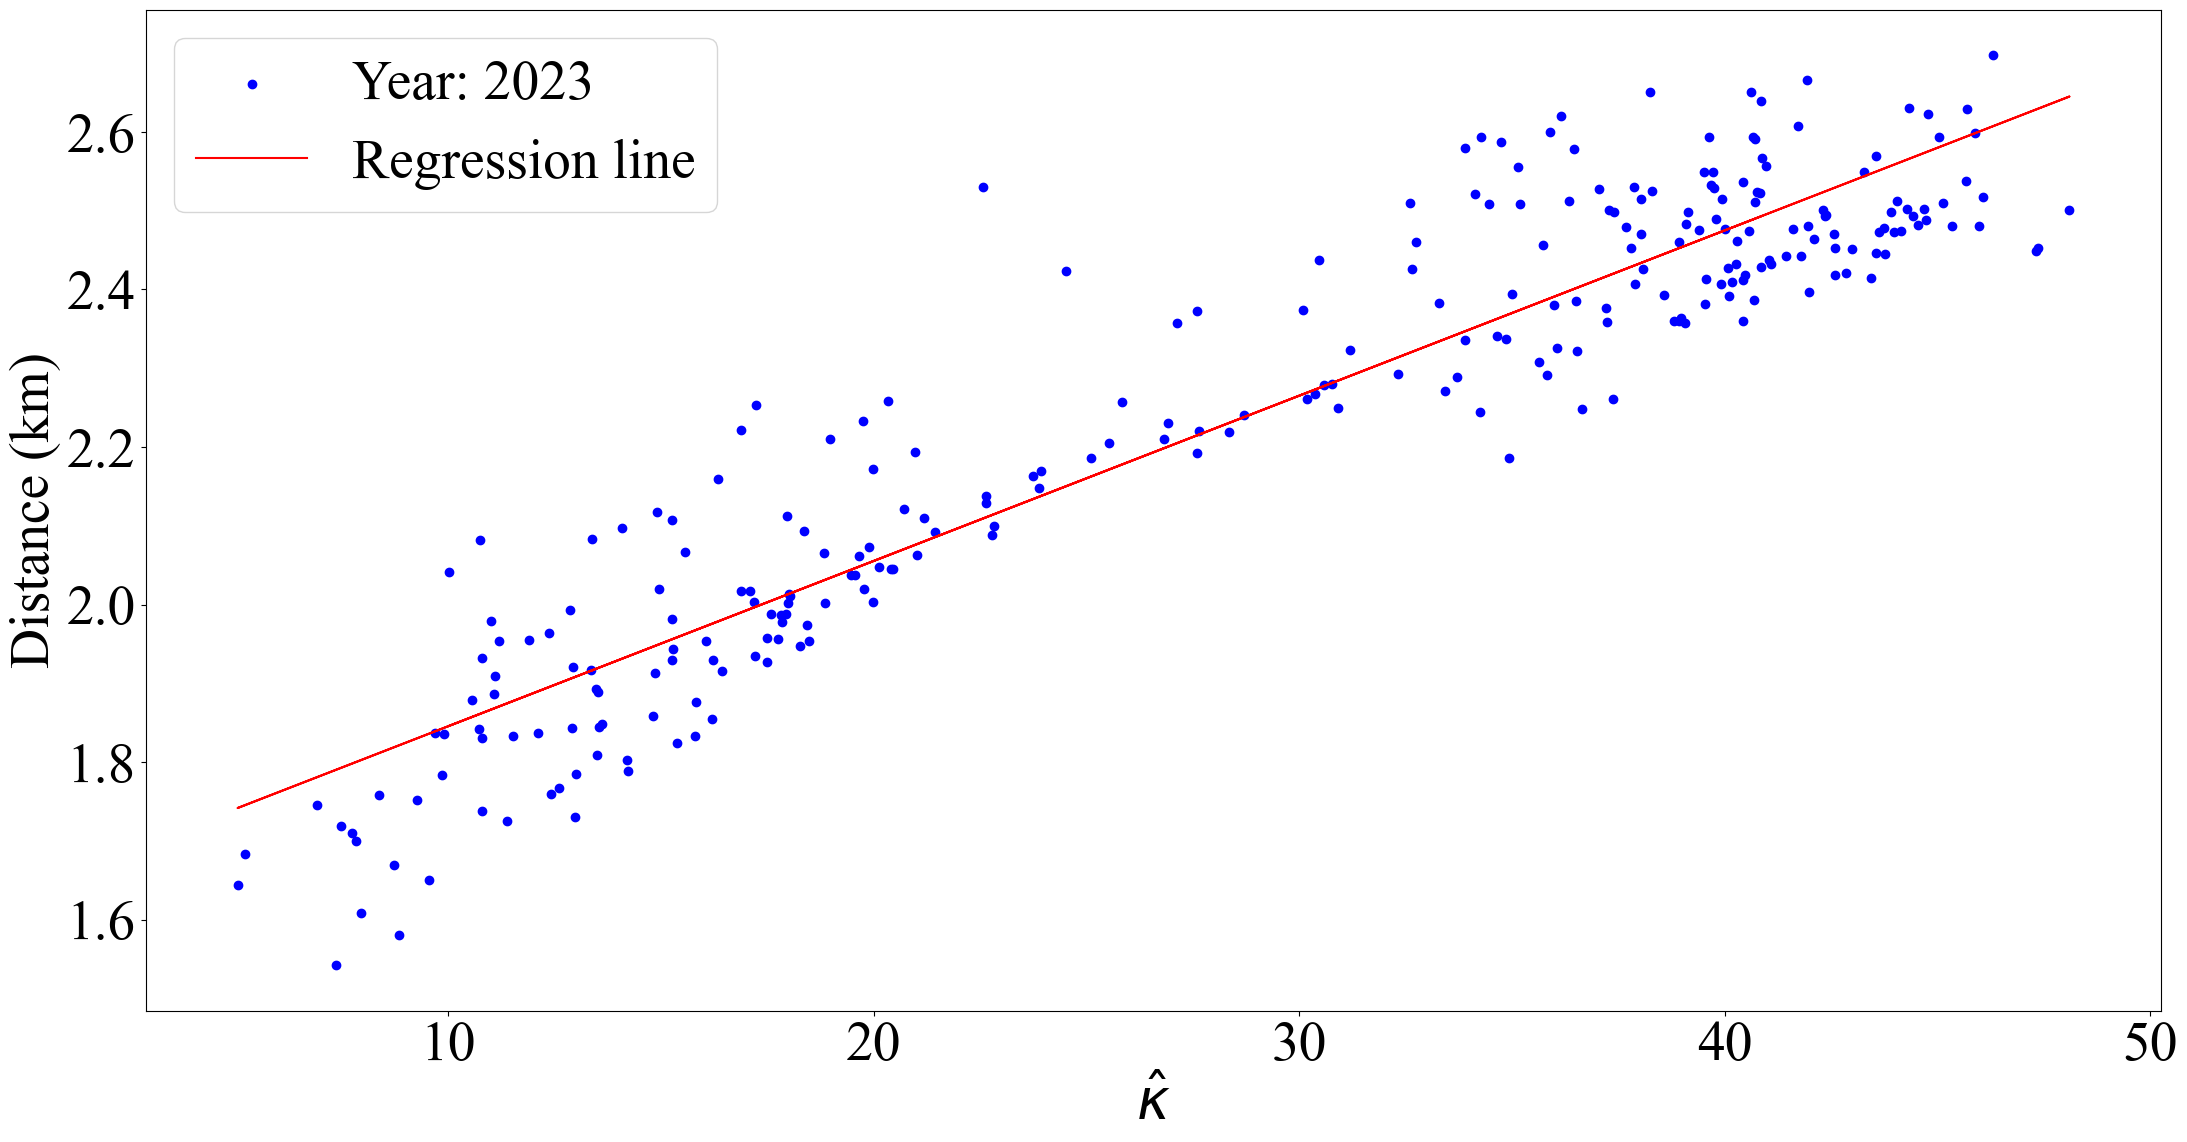

In [77]:
# 2023年のkappaと距離の関係
# olsを用いて回帰分析を行う
kappa_distance_2023_df = pd.DataFrame({"kappa": kappa_2023, "distance": distance_2023})

# kappa_distance_2023_dfのうち、3km以上のデータの行を削除
kappa_distance_2023_df = kappa_distance_2023_df[kappa_distance_2023_df["distance"] < 3]
# kappa_distance.head()

model = smf.ols("distance ~ kappa", data=kappa_distance_2023_df)
result = model.fit()

plt.figure(figsize=(26, 13))
plt.rcParams["font.size"] = 30
plt.rcParams["font.family"] = "Times New Roman"

plt.scatter(kappa_distance_2023_df["kappa"], kappa_distance_2023_df["distance"], label="Year: 2023", color="blue")
plt.plot(kappa_distance_2023_df["kappa"], result.fittedvalues, color="red", label="Regression line")
# plt.text(0.2, 0.1, f"y = {result.params[1]:.3f} + {result.params[0]:.3f}", transform=plt.gca().transAxes, fontsize=30)

plt.xlabel(r"$\hat{\kappa}$", fontsize=40)
plt.ylabel("Distance (km)", fontsize=40)
plt.tick_params(labelsize=40)
plt.legend(prop={"size": 40})
plt.savefig("../fig/cssj/kappa_distance_2023.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

In [78]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1782.
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          1.12e-120
Time:                        21:31:55   Log-Likelihood:                 235.66
No. Observations:                 271   AIC:                            -467.3
Df Residuals:                     269   BIC:                            -460.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6357      0.015    105.569      0.0

# 過去の分析ノート

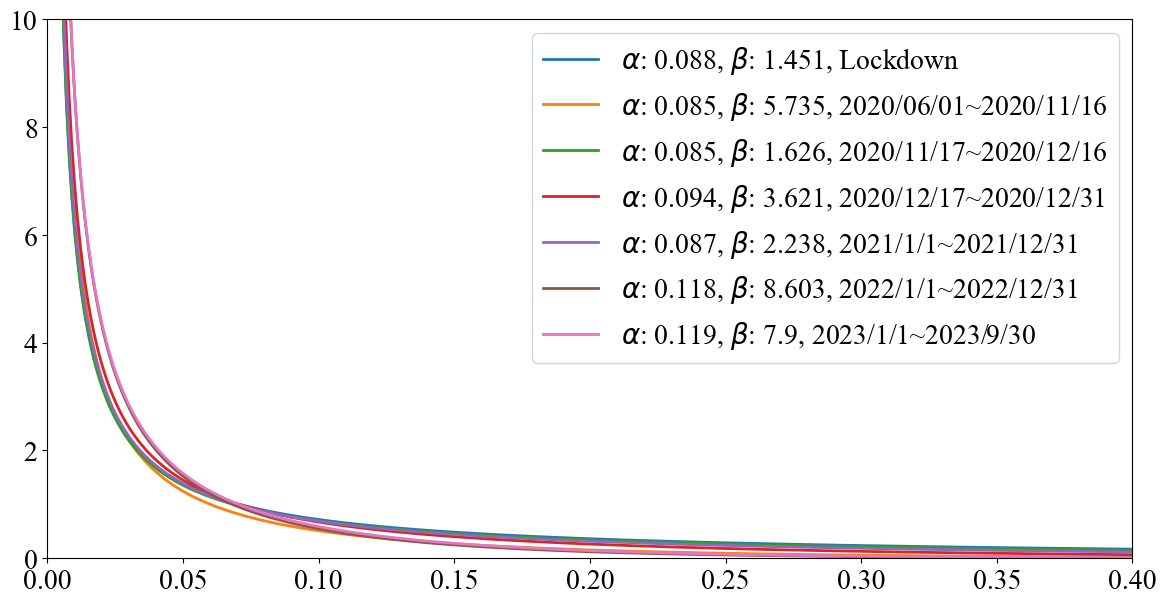

In [181]:
from pyparsing import line


plt.figure(figsize=(14, 7))
a = np.linspace(0, 1, 1000)

for i in range(len(alpha_list)):
    # log-log plot
    plt.plot(a, rho(a, alpha_list[i], beta_list[i]), label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[i], beta_list[i], label_list[i]), linewidth=2)

# x軸の範囲を0.4までに設定
plt.xlim(0, 0.4)
plt.ylim(0, 10)
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

In [182]:
df_2020 = df[df["started_at"] < "2021-01-01"].dropna()

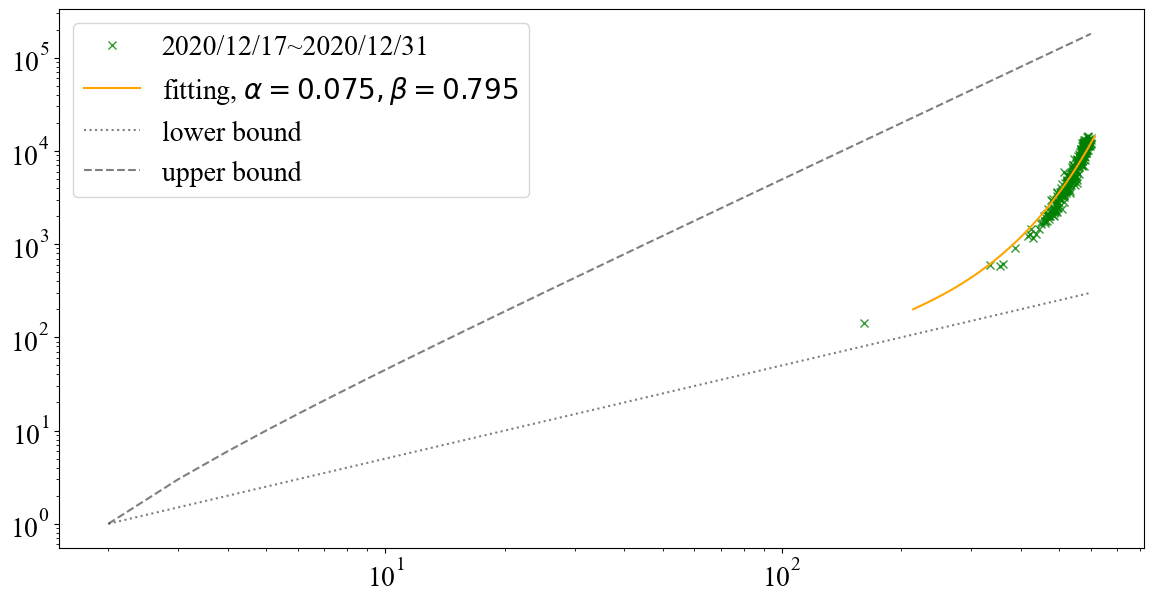

In [183]:
# lockdownにおけるネットワークのノード数とエッジ数の推移
plt.figure(figsize=(14, 7))

N = node_2020
M = edge_2020

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8, label="2020/12/17~2020/12/31")

Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)


#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

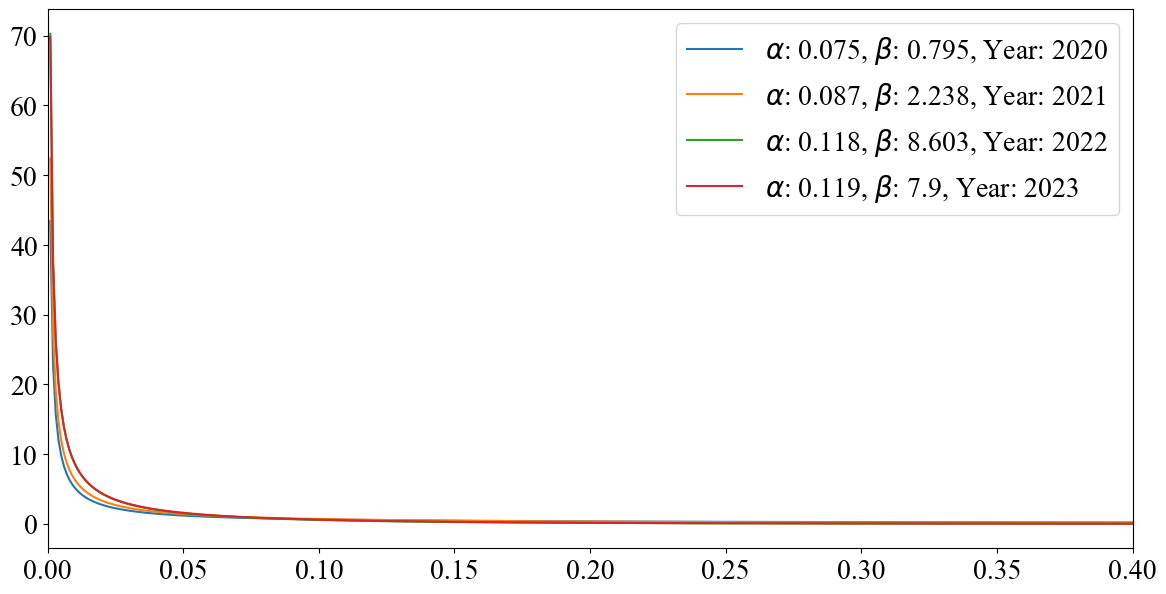

In [184]:
alpha_list = [0.075, 0.087, 0.118, 0.119]
beta_list = [0.795, 2.238, 8.603, 7.9]

plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

a = np.linspace(0, 1, 1000)
label_list = ['Year: 2020', 'Year: 2021', 'Year: 2022', 'Year: 2023']

for i in range(len(alpha_list)):
    # log-log plot
    plt.plot(a, rho(a, alpha_list[i], beta_list[i]), label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[i], beta_list[i], label_list[i]), )

# x軸の範囲を0.4までに設定
plt.xlim(0, 0.4)
#plt.ylim(0, 40)
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

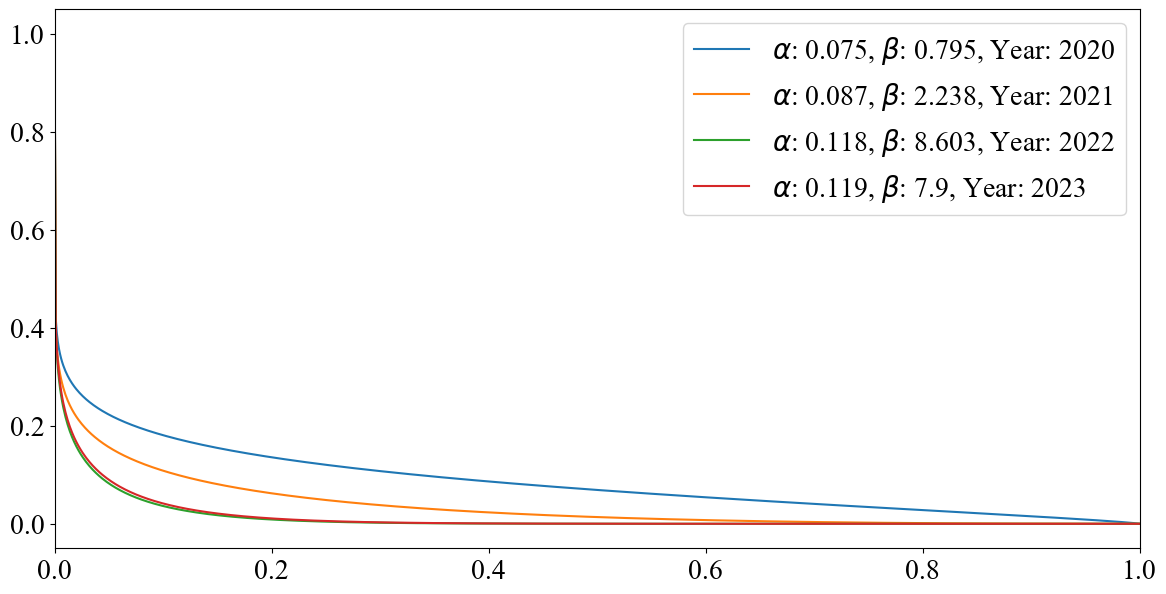

In [185]:
a = np.linspace(0, 1, 1000)
label_list = ['Year: 2020', 'Year: 2021', 'Year: 2022', 'Year: 2023']
alpha_list = [0.075, 0.087, 0.118, 0.119]
beta_list = [0.795, 2.238, 8.603, 7.9]

plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

for i in range(len(alpha_list)):
    # log-log plot
    y = 1 - stats.beta.cdf(a, alpha_list[i], beta_list[i])
    plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[i], beta_list[i], label_list[i]))

# x軸の範囲を0.4までに設定
plt.xlim(0, 1)
#plt.ylim(0, 40)
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

In [186]:
# 2020年のkappa
kappa_2020 = []
alpha = 0.068
beta = 0.519
for i in range(len(edge_2020)):
    kappa_2020.append(kappa(edge_2020[i], Np))

# 2021年のkappa
kappa_2021 = []
alpha = 0.068
beta = 1.903
for i in range(len(edge_2021)):
    kappa_2021.append(kappa(edge_2021[i], Np))

# 2022年のkappa
kappa_2022 = []
alpha = 0.118
beta = 8.603
for i in range(len(edge_2022)):
    kappa_2022.append(kappa(edge_2022[i], Np))

# 2023年のkappa
kappa_2023 = []
alpha = 0.119
beta = 7.662
for i in range(len(edge_2023)):
    kappa_2023.append(kappa(edge_2023[i], Np))

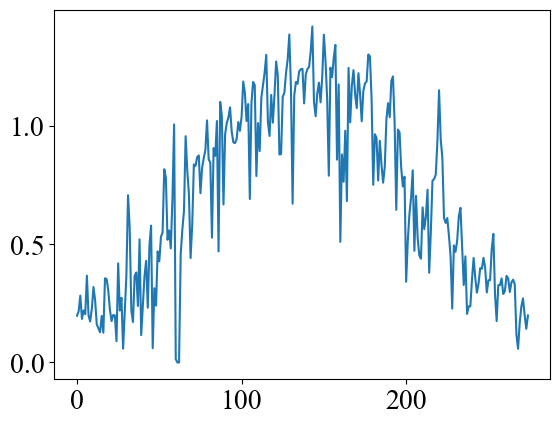

In [253]:
plt.plot(kappa_2020, label="2020")

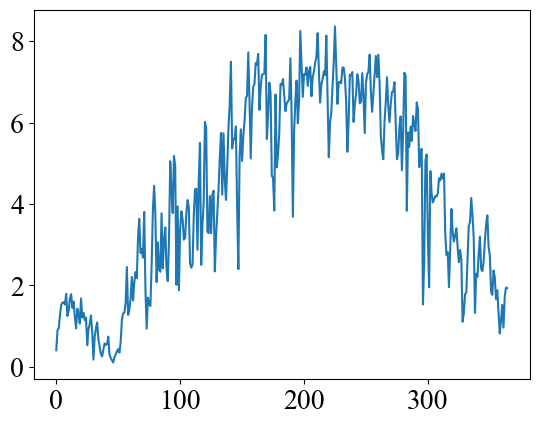

In [254]:
plt.plot(kappa_2021, label="2021")

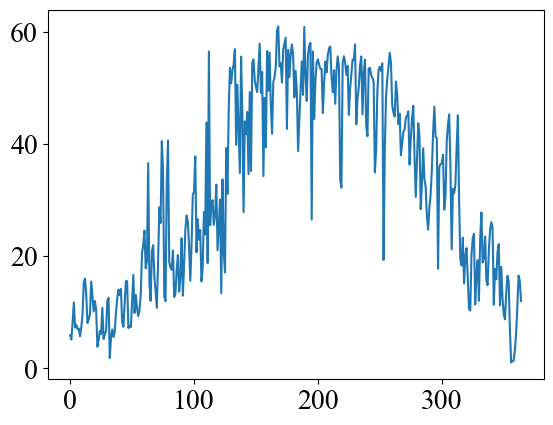

In [255]:
plt.plot(kappa_2022, label="2022")

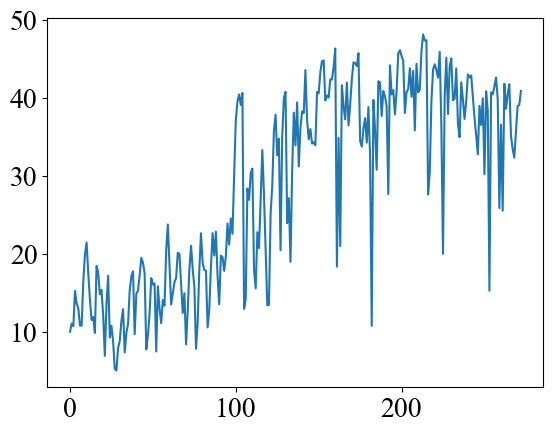

In [256]:
plt.plot(kappa_2023, label="2023")

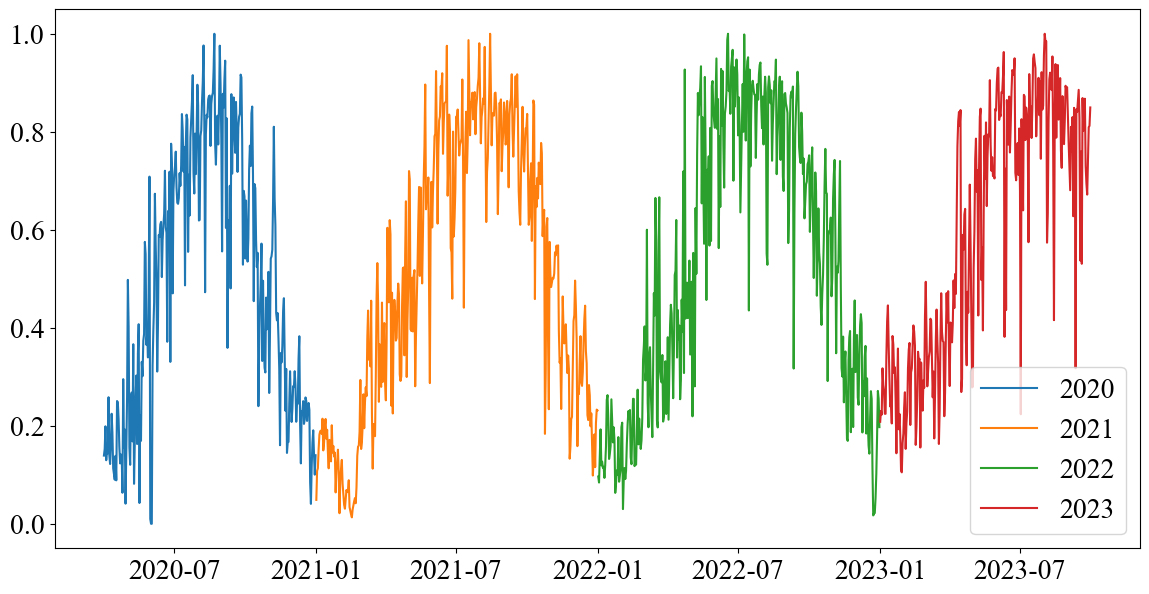

In [259]:
# 正規化する
kappa_2020 = np.array(kappa_2020) / np.max(kappa_2020)
kappa_2021 = np.array(kappa_2021) / np.max(kappa_2021)
kappa_2022 = np.array(kappa_2022) / np.max(kappa_2022)
kappa_2023 = np.array(kappa_2023) / np.max(kappa_2023)

plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_2020, kappa_2020, label="2020")
plt.plot(timestamp_2021, kappa_2021, label="2021")
plt.plot(timestamp_2022, kappa_2022, label="2022")
plt.plot(timestamp_2023, kappa_2023, label="2023")

plt.legend()
plt.show()

In [239]:
rho_2020 = 1 - stats.beta.cdf(a, alpha_list[0], beta_list[0])
rho_2021 = 1 - stats.beta.cdf(a, alpha_list[1], beta_list[1])
rho_2022 = 1 - stats.beta.cdf(a, alpha_list[2], beta_list[2])
rho_2023 = 1 - stats.beta.cdf(a, alpha_list[3], beta_list[3])


rho_2020 = np.array(rho_2020)
rho_2020 = rho_2020[np.isfinite(rho_2020)]

rho_2021 = np.array(rho_2021)
rho_2021 = rho_2021[np.isfinite(rho_2021)]

rho_2022 = np.array(rho_2022)
rho_2022 = rho_2022[np.isfinite(rho_2022)]

rho_2023 = np.array(rho_2023)
rho_2023 = rho_2023[np.isfinite(rho_2023)]

# power law fitting
fit_2020 = powerlaw.Fit(rho_2020)
fit_2021 = powerlaw.Fit(rho_2021)
fit_2022 = powerlaw.Fit(rho_2022)
fit_2023 = powerlaw.Fit(rho_2023)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [240]:
rho_2020

array([1.00000000e+00, 4.20839807e-01, 3.89926477e-01, 3.71080228e-01,
       3.57353888e-01, 3.46498829e-01, 3.37491885e-01, 3.29778348e-01,
       3.23022716e-01, 3.17006162e-01, 3.11577824e-01, 3.06629180e-01,
       3.02079485e-01, 2.97866996e-01, 2.93943414e-01, 2.90270228e-01,
       2.86816224e-01, 2.83555742e-01, 2.80467425e-01, 2.77533305e-01,
       2.74738116e-01, 2.72068777e-01, 2.69513991e-01, 2.67063933e-01,
       2.64710004e-01, 2.62444634e-01, 2.60261123e-01, 2.58153511e-01,
       2.56116476e-01, 2.54145241e-01, 2.52235503e-01, 2.50383373e-01,
       2.48585326e-01, 2.46838150e-01, 2.45138919e-01, 2.43484952e-01,
       2.41873790e-01, 2.40303171e-01, 2.38771012e-01, 2.37275386e-01,
       2.35814509e-01, 2.34386727e-01, 2.32990503e-01, 2.31624404e-01,
       2.30287095e-01, 2.28977329e-01, 2.27693938e-01, 2.26435830e-01,
       2.25201977e-01, 2.23991415e-01, 2.22803237e-01, 2.21636589e-01,
       2.20490664e-01, 2.19364701e-01, 2.18257980e-01, 2.17169822e-01,
      

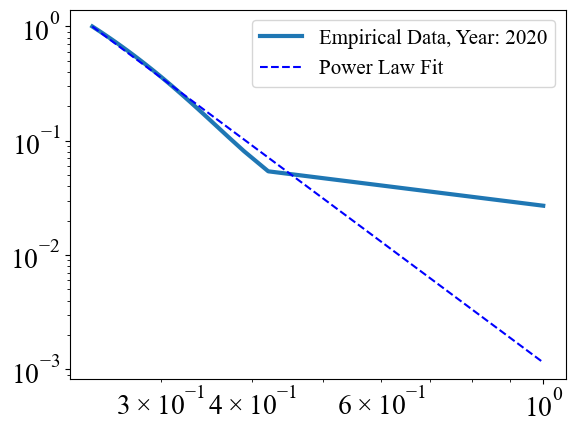

In [241]:
fig = fit_2020.plot_ccdf(linewidth=3, label='Empirical Data, Year: 2020')
fit_2020.power_law.plot_ccdf(ax=fig, color='b', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 15})

In [242]:
R, p = fit_2020.distribution_compare('power_law', 'exponential')
R_lognormal, p_lognormal = fit_2020.distribution_compare('power_law', 'lognormal')

# 結果の出力
print(f"冪乗則 vs 指数分布: R = {R}, p = {p}")
print(f"冪乗則 vs 対数正規分布: R = {R_lognormal}, p = {p_lognormal}")

冪乗則 vs 指数分布: R = 3.4746897873925184, p = 0.2912467801042943
冪乗則 vs 対数正規分布: R = -0.3489744331929272, p = 0.17837293438083446


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


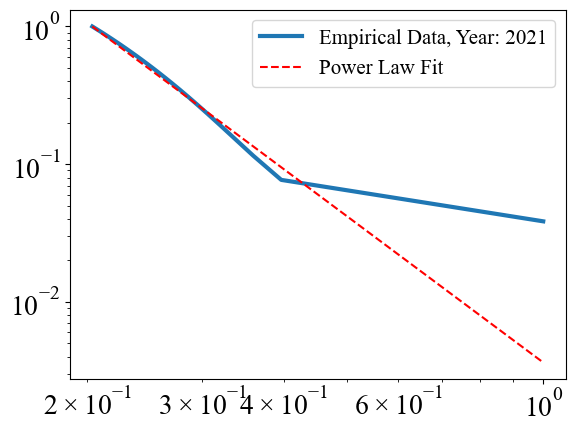

In [243]:
fig = fit_2021.plot_ccdf(linewidth=3, label='Empirical Data, Year: 2021')
fit_2021.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 15})

In [244]:
R, p = fit_2021.distribution_compare('power_law', 'exponential')
R_lognormal, p_lognormal = fit_2021.distribution_compare('power_law', 'lognormal')

# 結果の出力
print(f"冪乗則 vs 指数分布: R = {R}, p = {p}")
print(f"冪乗則 vs 対数正規分布: R = {R_lognormal}, p = {p_lognormal}")

冪乗則 vs 指数分布: R = 2.9153381803003944, p = 0.2791997302343876
冪乗則 vs 対数正規分布: R = -0.13173930968570016, p = 0.2120944506940029


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


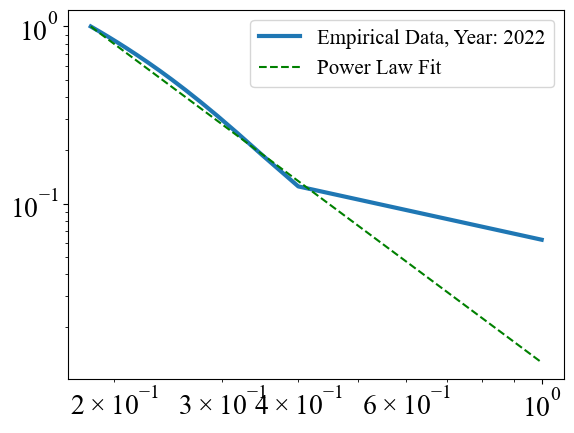

In [245]:
fig = fit_2022.plot_ccdf(linewidth=3, label='Empirical Data, Year: 2022')
fit_2022.power_law.plot_ccdf(ax=fig, color='g', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 15})

In [246]:
R, p = fit_2022.distribution_compare('power_law', 'exponential')
R_lognormal, p_lognormal = fit_2022.distribution_compare('power_law', 'lognormal')

# 結果の出力
print(f"冪乗則 vs 指数分布: R = {R}, p = {p}")
print(f"冪乗則 vs 対数正規分布: R = {R_lognormal}, p = {p_lognormal}")

冪乗則 vs 指数分布: R = 1.8340316531095657, p = 0.29251819709884497
冪乗則 vs 対数正規分布: R = -0.44984874306437506, p = 0.09507775825899589


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


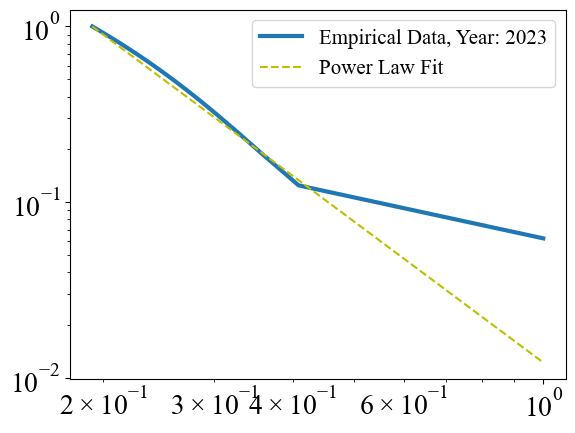

In [247]:
fig = fit_2023.plot_ccdf(linewidth=3, label='Empirical Data, Year: 2023')
fit_2023.power_law.plot_ccdf(ax=fig, color='y', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 15})

In [248]:
R, p = fit_2023.distribution_compare('power_law', 'exponential')
R_lognormal, p_lognormal = fit_2023.distribution_compare('power_law', 'lognormal')

# 結果の出力
print(f"冪乗則 vs 指数分布: R = {R}, p = {p}")
print(f"冪乗則 vs 対数正規分布: R = {R_lognormal}, p = {p_lognormal}")

冪乗則 vs 指数分布: R = 1.7717602093946097, p = 0.2927363436706597
冪乗則 vs 対数正規分布: R = -0.49327758199208593, p = 0.05892287489033551


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [118]:
# ロックダウン解除と自宅待機勧告

alpha_stay = [0.085, 0.085]
beta_stat = [5.735, 1.626]

kappa_list_before = []
kappa_list_after = []

for i in range(len(edge_20200601_20201116)):
    kappa_list_before.append(kappa(edge_20200601_20201116[i], Np))

for i in range(len(edge_20201117_20201216)):
    kappa_list_after.append(kappa(edge_20201117_20201216[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_list_before, len(kappa_list_after)), kappa_list_after)[0, 1])
    


0.22056098000312782


In [141]:
alpha = [0.088, 0.087]
beta = [1.451, 2.238]

kappa_a = []
kappa_b = []

for i in range(len(edge_lockdown)):
    alpha = 0.088
    beta = 1.451
    kappa_a.append(kappa(edge_lockdown[i], Np))

for i in range(len(edge_2021)):
    alpha = 0.087
    beta = 2.238
    kappa_b.append(kappa(edge_2021[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_a, len(kappa_b)), kappa_b)[0, 1])

-0.10816556556166614


In [142]:
kappa_a = []
kappa_b = []

for i in range(len(edge_20201117_20201216)):
    alpha = 0.085
    beta = 1.626
    kappa_a.append(kappa(edge_20201117_20201216[i], Np))

for i in range(len(edge_2021)):
    alpha = 0.087
    beta = 2.238
    kappa_b.append(kappa(edge_2021[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_a, len(kappa_b)), kappa_b)[0, 1])

0.10678960918093057


In [145]:
kappa_a = []
kappa_b = []

for i in range(len(edge_lockdown)):
    alpha = 0.088
    beta = 1.451
    kappa_a.append(kappa(edge_lockdown[i], Np))

for i in range(len(edge_2022)):
    alpha = 0.118
    beta = 8.603
    kappa_b.append(kappa(edge_2022[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_a, len(kappa_b)), kappa_b)[0, 1])

0.056882324306535705


In [148]:
kappa_a = []
kappa_b = []

for i in range(len(edge_20201117_20201216)):
    alpha = 0.085
    beta = 1.626
    kappa_a.append(kappa(edge_20201117_20201216[i], Np))

for i in range(len(edge_2023)):
    alpha = 0.119
    beta = 7.9
    kappa_b.append(kappa(edge_2023[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_b, len(kappa_a)), kappa_a)[0, 1])

-0.08206065176702934


In [149]:
kappa_a = []
kappa_b = []

for i in range(len(edge_lockdown)):
    alpha = 0.088
    beta = 1.451
    kappa_a.append(kappa(edge_lockdown[i], Np))

for i in range(len(edge_2023)):
    alpha = 0.119
    beta = 7.9
    kappa_b.append(kappa(edge_2023[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_b, len(kappa_a)), kappa_a)[0, 1])

-0.04213304328564475


In [150]:
sah = []
asah = []

for i in range(len(edge_20201117_20201216)):
    alpha = 0.085
    beta = 1.626
    sah.append(kappa(edge_20201117_20201216[i], Np))

for i in range(len(edge_20201217_20201231)):
    alpha = 0.094
    beta = 3.621
    asah.append(kappa(edge_20201217_20201231[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(sah, len(asah)), asah)[0, 1])

-0.22916283257637862


In [154]:
# df_2020_normalのalphaとbetaの推定
node_2020_normal, edge_2020_normal, timestamp_2020_normal = getNetworkAnalysis(df_2020_normal)

N = node_2020_normal
M = edge_2020_normal

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))


Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

print("alpha: ", alpha)
print("beta: ", beta)

alpha:  0.081
beta:  1.761


In [158]:
lockdown = []
normal = []

for i in range(len(edge_lockdown)):
    alpha = 0.088
    beta = 1.451
    lockdown.append(kappa(edge_lockdown[i], Np))

for i in range(len(edge_2020_normal)):
    alpha = 0.081
    beta = 1.761
    normal.append(kappa(edge_2020_normal[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(normal, len(lockdown)), lockdown)[0, 1])

0.03244752231521197


In [156]:
print(len(lockdown))
print(len(normal))

61
212


In [162]:
stay = []
normal = []

for i in range(len(edge_20201117_20201216)):
    alpha = 0.085
    beta = 1.626
    stay.append(kappa(edge_20201117_20201216[i], Np))

for i in range(len(edge_2020_normal)):
    alpha = 0.081
    beta = 1.761
    normal.append(kappa(edge_2020_normal[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(normal, len(stay)), stay)[0, 1])

-0.33518701420588415


In [161]:
print(len(stay))
print(len(normal))

30
212


In [164]:
# 距離とkappaの回帰分析
node_df, edge_df, timestamp_df, distance_df = getNetworkAnalysis(df)


In [180]:
len(edge_df)

1278

In [181]:
len(distance_df)

1278

In [182]:
len(kappa_distance["kappa"])

1278

In [165]:
params, _ = optimize.curve_fit(Model3_fixed, edge_df, node_df, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

# 活動量の計算
kappa_list = []
for i in range(len(edge_df)):
    kappa_list.append(kappa(edge_df[i], Np))

In [170]:
kappa_distance = pd.DataFrame({"kappa": kappa_list, "distance": distance_df})
kappa_distance.head()

,kappa,distance
0,1.417870,2.180333
1,1.553073,2.225399
2,2.026641,2.362661
3,1.321599,2.301933
4,1.578557,2.408816


In [172]:
# olsを使用して分析を行う
formula = "distance ~ kappa"
res = ols(formula, data=kappa_distance).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     989.2
Date:                Sat, 20 Jan 2024   Prob (F-statistic):          3.63e-161
Time:                        19:42:50   Log-Likelihood:                -187.90
No. Observations:                1276   AIC:                             379.8
Df Residuals:                    1274   BIC:                             390.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8130      0.017    106.631      0.0

In [173]:
# resをlatex形式で出力する
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &     distance     & \textbf{  R-squared:         } &      0.437    \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &      0.437    \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &      989.2    \\
\textbf{Date:}             & Sat, 20 Jan 2024 & \textbf{  Prob (F-statistic):} &  3.63e-161    \\
\textbf{Time:}             &     19:43:21     & \textbf{  Log-Likelihood:    } &    -187.90    \\
\textbf{No. Observations:} &        1276      & \textbf{  AIC:               } &      379.8    \\
\textbf{Df Residuals:}     &        1274      & \textbf{  BIC:               } &      390.1    \\
\textbf{Df Model:}         &           1      & \textbf{                     } &               \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &               \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                   & 

In [176]:
distance_hat = res.fittedvalues

In [178]:
len(kappa_distance)

1278

In [179]:
len(distance_hat)

1276

In [206]:
x = kappa_distance["kappa"]
y = kappa_distance["distance"]

def func(kappa):
    return kappa*kappa

model = smf.ols(formula='distance ~ kappa', data=kappa_distance).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     989.2
Date:                Sat, 20 Jan 2024   Prob (F-statistic):          3.63e-161
Time:                        20:11:57   Log-Likelihood:                -187.90
No. Observations:                1276   AIC:                             379.8
Df Residuals:                    1274   BIC:                             390.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8130      0.017    106.631      0.0

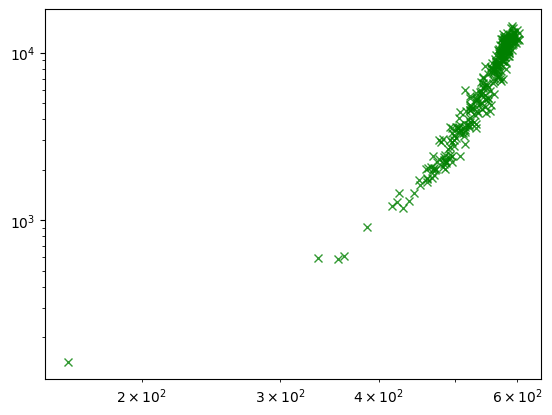

In [28]:
from math import log


N = node_2020
M = edge_2020

"""
N_ = [x for x, y in zip(N, M) if x != 0 and y != 0]
M_ = [y for x, y in zip(N, M) if x != 0 and y != 0]

logN = np.log(N_)
logM = np.log(M_)
"""

plt.plot(N, M, "x", c="green", alpha=0.8, label="2020/12/17~2020/12/31")
plt.xscale('log')
plt.yscale('log')
plt.show()


In [27]:
print(N)

[471, 487, 514, 470, 495, 483, 521, 485, 461, 484, 498, 490, 451, 444, 437, 469, 422, 506, 521, 501, 487, 467, 470, 473, 387, 530, 474, 498, 335, 484, 531, 568, 538, 486, 450, 519, 529, 496, 533, 429, 493, 516, 548, 492, 541, 539, 361, 513, 485, 532, 534, 550, 545, 546, 566, 545, 560, 556, 560, 569, 161, 0, 0, 541, 539, 547, 564, 567, 567, 554, 554, 565, 567, 568, 578, 567, 564, 563, 572, 567, 557, 564, 550, 562, 575, 578, 546, 571, 568, 560, 571, 576, 584, 579, 576, 577, 579, 573, 580, 585, 580, 572, 573, 584, 582, 570, 582, 573, 577, 558, 584, 573, 577, 580, 587, 582, 578, 571, 575, 574, 586, 592, 577, 564, 575, 597, 581, 577, 576, 592, 579, 572, 579, 578, 588, 590, 590, 592, 587, 584, 592, 587, 594, 591, 590, 580, 591, 580, 578, 591, 589, 594, 592, 555, 595, 591, 594, 600, 580, 599, 551, 576, 572, 585, 576, 590, 586, 589, 579, 586, 573, 587, 594, 590, 593, 602, 601, 593, 602, 577, 555, 573, 576, 561, 570, 571, 567, 568, 574, 579, 581, 587, 592, 580, 558, 568, 573, 563, 558, 581, 507

In [16]:
from math import log


N = node_2021
M = edge_2021

N_ = [x for x, y in zip(N, M) if x != 0 and y != 0]
M_ = [y for x, y in zip(N, M) if x != 0 and y != 0]

logN = np.log(N_)
logM = np.log(M_)

slope, intercept, r_value, p_value, std_err = stats.linregress(logN, logM)

print("slope: ", slope)

slope:  4.41478265833791


In [17]:
from math import log


N = node_2022
M = edge_2022

N_ = [x for x, y in zip(N, M) if x != 0 and y != 0]
M_ = [y for x, y in zip(N, M) if x != 0 and y != 0]

logN = np.log(N_)
logM = np.log(M_)

slope, intercept, r_value, p_value, std_err = stats.linregress(logN, logM)

print("slope: ", slope)

slope:  3.5730801152271754


In [22]:
from math import log


N = node_2023
M = edge_2023

N_ = [x for x, y in zip(N, M) if x != 0 and y != 0]
M_ = [y for x, y in zip(N, M) if x != 0 and y != 0]

logN = np.log(N_)
logM = np.log(M_)

slope, intercept, r_value, p_value, std_err = stats.linregress(logN, logM)

print("slope: ", slope)
print("R value: ", r_value)

slope:  4.598491461407641
R value:  0.9811981020483975


In [21]:
0 in N_

False

## カンファレンス用

In [187]:
Np = 1652
N = node_2020
M = edge_2020

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

print("alpha: ", alpha)
print("beta: ", beta) 

alpha:  0.075
beta:  0.795


In [188]:
alpha_list = []
beta_list = []

alpha_list.append(alpha)
beta_list.append(beta)

In [189]:
N = node_2021
M = edge_2021

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

print("alpha: ", alpha)
print("beta: ", beta) 

alpha_list.append(alpha)
beta_list.append(beta)

alpha:  0.087
beta:  2.238


In [190]:
N = node_2022
M = edge_2022

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

print("alpha: ", alpha)
print("beta: ", beta) 

alpha_list.append(alpha)
beta_list.append(beta)

alpha:  0.118
beta:  8.603


In [191]:
N = node_2023
M = edge_2023

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

print("alpha: ", alpha)
print("beta: ", beta) 

alpha_list.append(alpha)
beta_list.append(beta)

alpha:  0.119
beta:  7.9


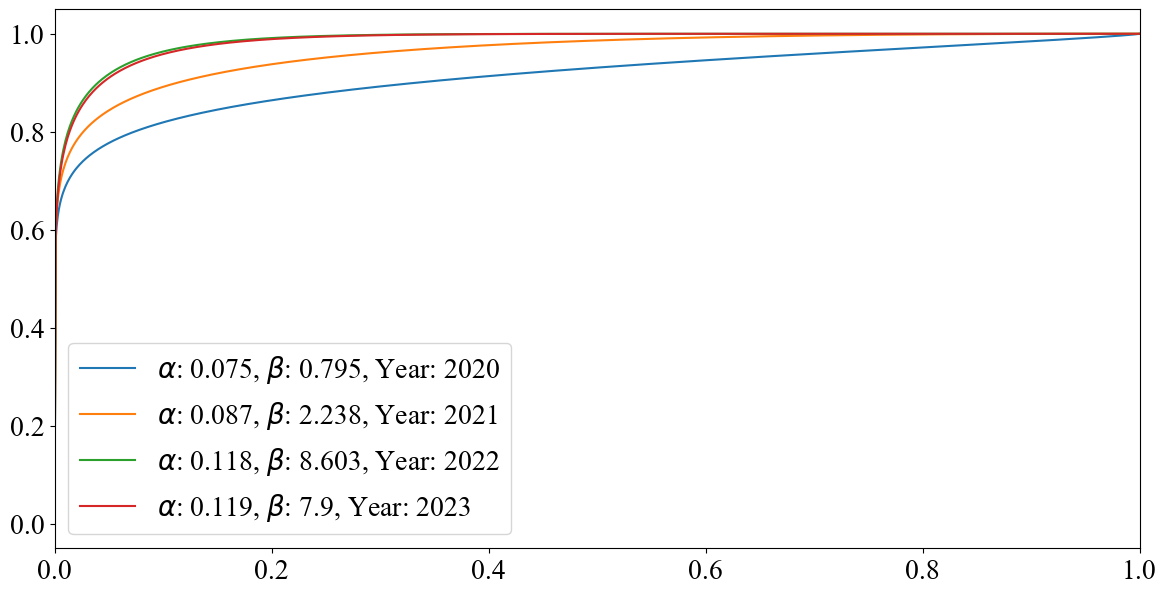

In [192]:
# 個々の年における活動量
a = np.linspace(0, 1, 1000)
label_list = ['Year: 2020', 'Year: 2021', 'Year: 2022', 'Year: 2023']

plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

for i in range(len(alpha_list)):
    # log-log plot
    y = stats.beta.cdf(a, alpha_list[i], beta_list[i])
    plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[i], beta_list[i], label_list[i]))

# x軸の範囲を0.4までに設定
plt.xlim(0, 1)
#plt.ylim(0, 40)
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

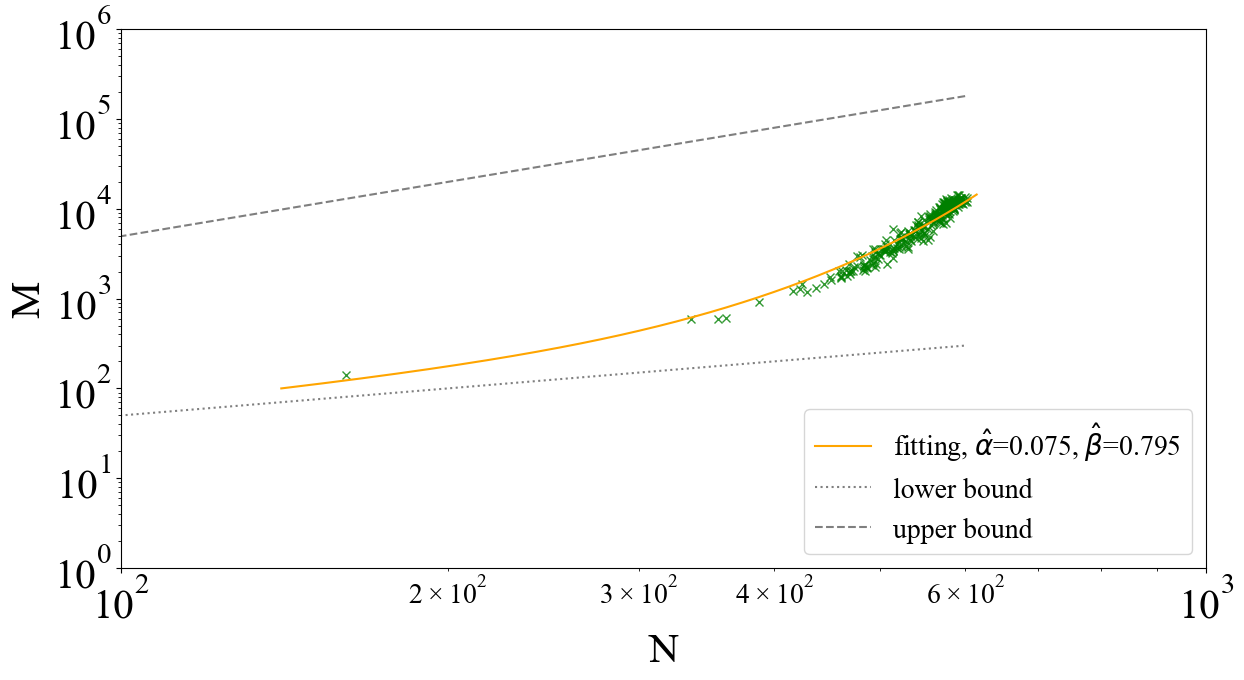

In [10]:
# 2020年のスケーリング則について
alpha = 0.075
beta = 0.795
Np = 1652

# ロックダウンの状態の時
plt.figure(figsize=(14, 7))

plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

N = node_2020
M = edge_2020

x = np.arange(2, np.max(N))
y = np.arange(100, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8)

# plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=fr"fitting, $\hat{{\alpha}}$={round(alpha, 3):.3f}, $\hat{{\beta}}$={round(beta, 3):.3f}", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xlim(100, 1000)
plt.ylim(1, 1000000)

plt.xlabel("N", fontsize=30)
plt.ylabel("M", fontsize=30)

plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=30)
plt.legend(prop={'size': 20})
plt.savefig("../fig/cssj/fit_2020.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

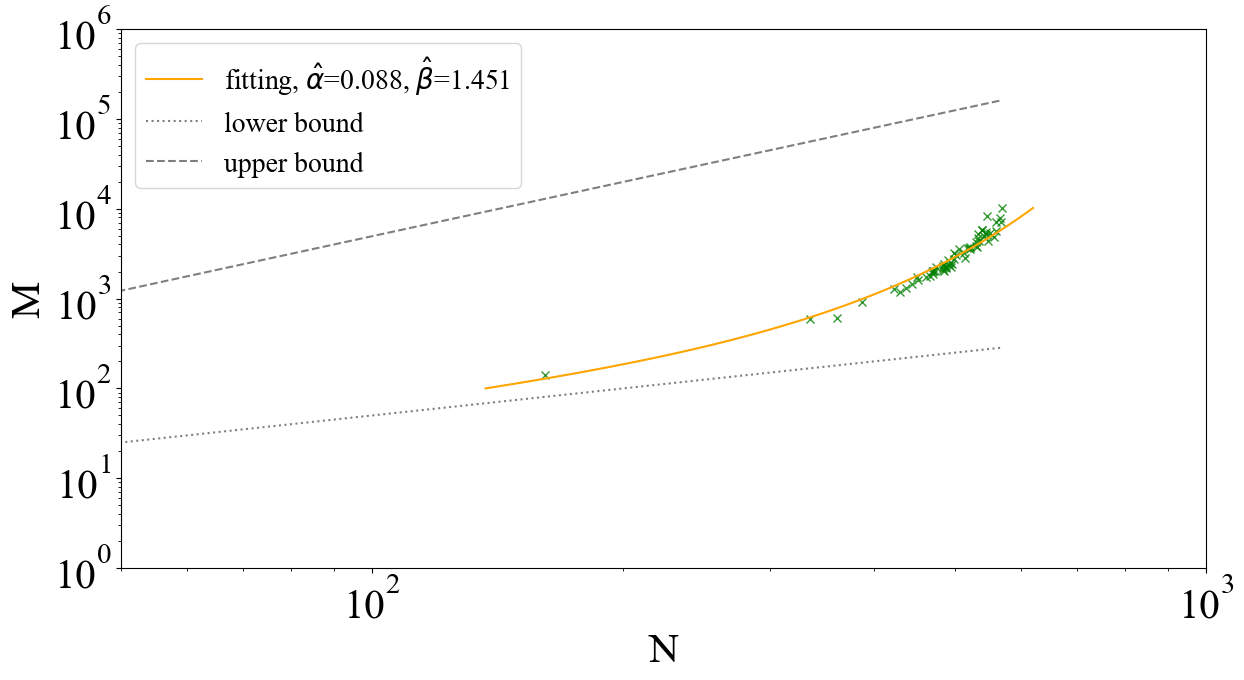

In [87]:
# ロックダウンの状態の時
plt.figure(figsize=(14, 7))

N = node_lockdown
M = edge_lockdown

x = np.arange(2, np.max(N))
y = np.arange(100, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8)

alpha = 0.088
beta = 1.451

# plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=fr"fitting, $\hat{{\alpha}}$={round(alpha, 3):.3f}, $\hat{{\beta}}$={round(beta, 3):.3f}", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xlim(50, 1000)
plt.ylim(1, 1000000)

plt.xlabel("N", fontsize=30)
plt.ylabel("M", fontsize=30)

plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=30)
plt.legend(prop={'size': 20})
plt.savefig("../fig/cssj/fit_lockdown.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

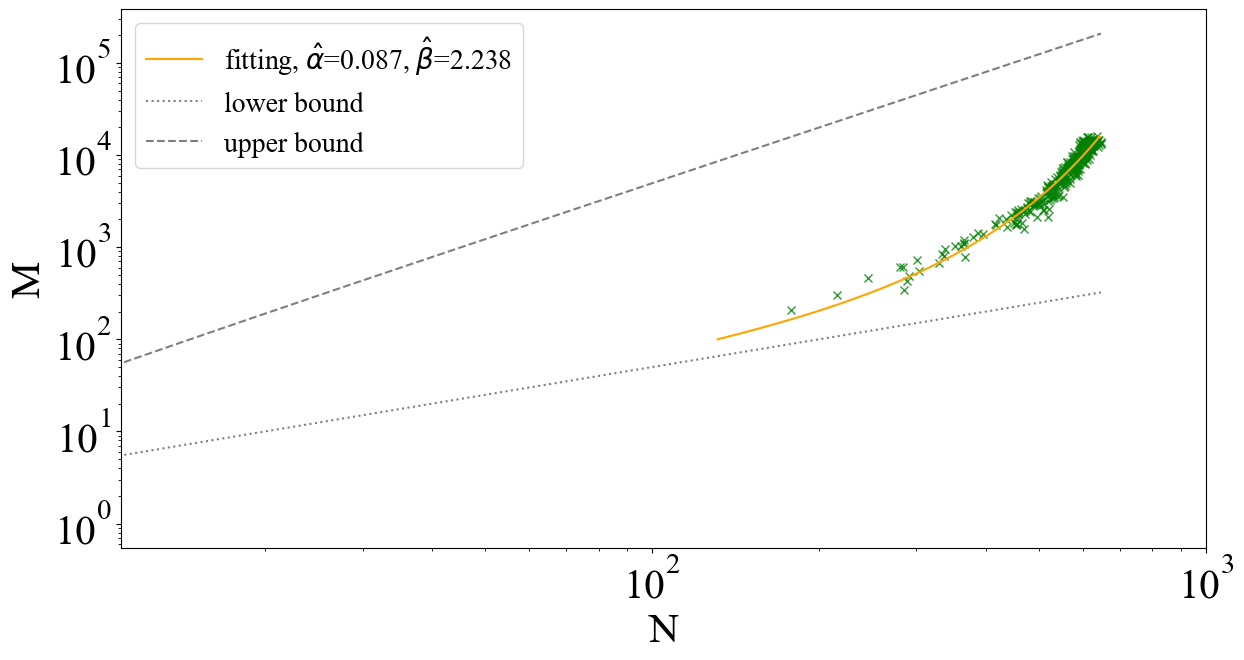

In [84]:
# 2021年の状態
plt.figure(figsize=(14, 7))

N = node_2021
M = edge_2021

x = np.arange(2, np.max(N))
y = np.arange(100, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8)

alpha = 0.087
beta = 2.238

# plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=fr"fitting, $\hat{{\alpha}}$={round(alpha_list[1], 3):.3f}, $\hat{{\beta}}$={round(beta_list[1], 3):.3f}", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xlabel("N", fontsize=30)
plt.ylabel("M", fontsize=30)

plt.xlim(10^1, 1000)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=30)
plt.legend(prop={'size': 20})
plt.savefig("../fig/cssj/fit_2021.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

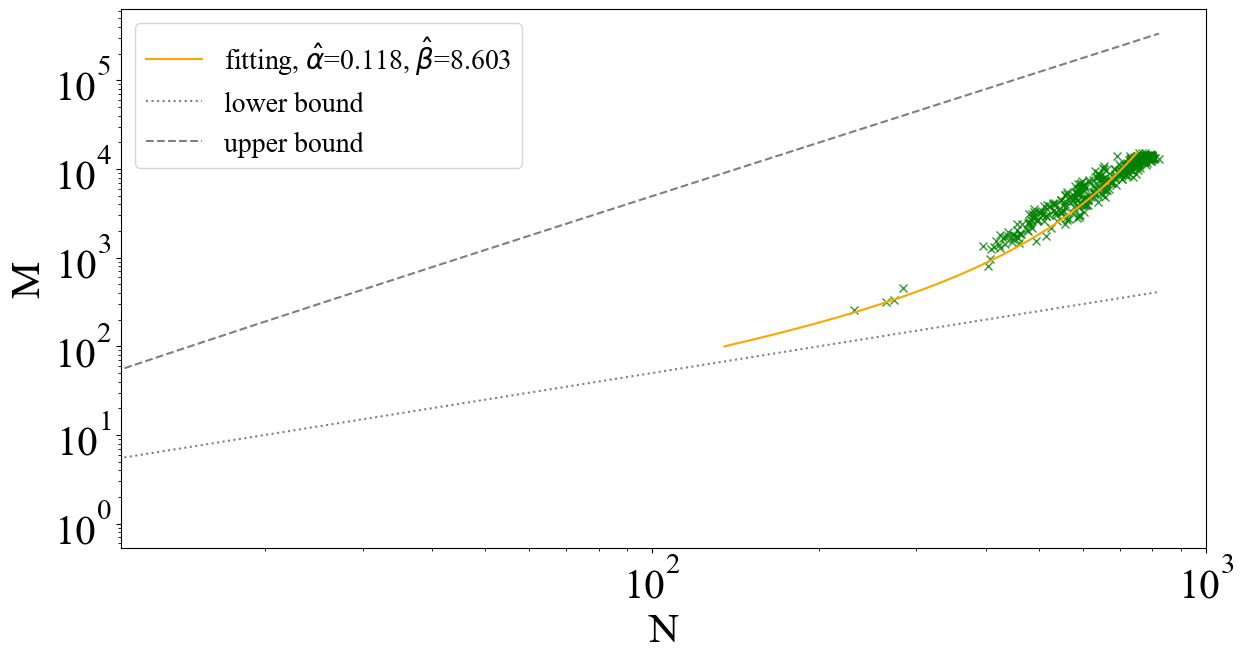

In [85]:
# 2022年の状態
plt.figure(figsize=(14, 7))

N = node_2022
M = edge_2022

x = np.arange(2, np.max(N))
y = np.arange(100, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8)

alpha = alpha_list[2]
beta = beta_list[2]

# plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=fr"fitting, $\hat{{\alpha}}$={round(alpha_list[2], 3):.3f}, $\hat{{\beta}}$={round(beta_list[2], 3):.3f}", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xlim(10^1, 1000)

plt.xlabel("N", fontsize=30)
plt.ylabel("M", fontsize=30)

plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=30)
plt.legend(prop={'size': 20})
plt.savefig("../fig/cssj/fit_2022.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

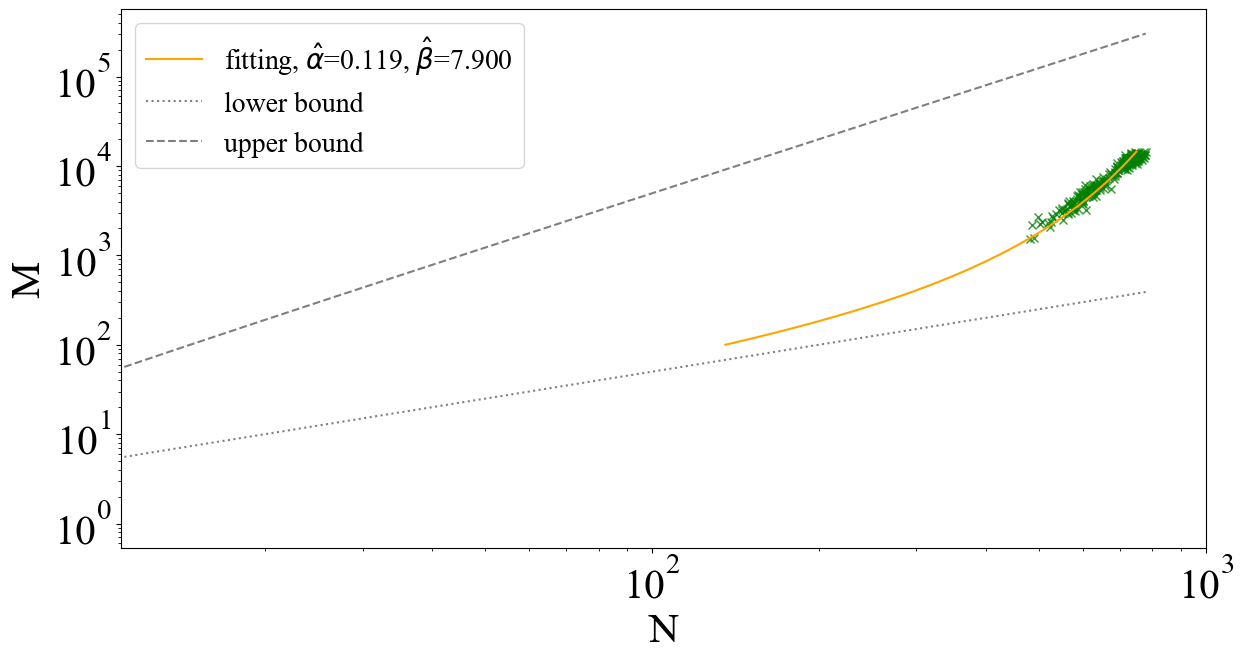

In [79]:
# 2023年の状態
plt.figure(figsize=(14, 7))

N = node_2023
M = edge_2023

x = np.arange(2, np.max(N))
y = np.arange(100, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8)

alpha = alpha_list[3]
beta = beta_list[3]

# plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=fr"fitting, $\hat{{\alpha}}$={round(alpha_list[3], 3):.3f}, $\hat{{\beta}}$={round(beta_list[3], 3):.3f}", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xlim(10^1, 1000)

plt.xlabel("N", fontsize=30)
plt.ylabel("M", fontsize=30)

plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=30)
plt.legend(prop={'size': 20})
plt.savefig("../fig/cssj/fit_2023.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

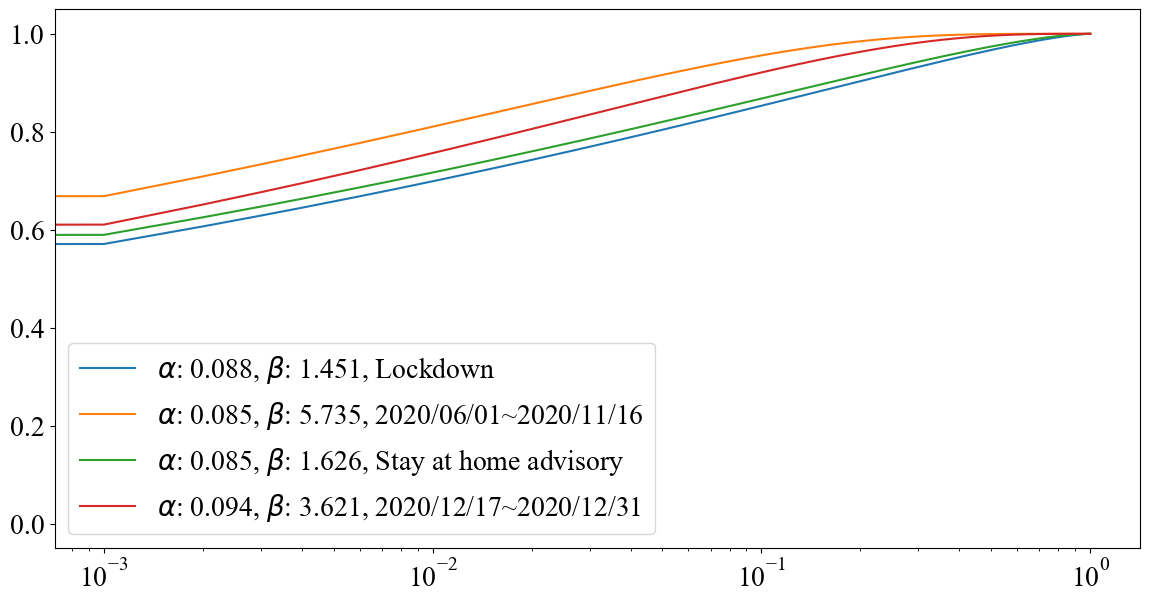

In [11]:
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

alpha_2020 = [0.088, 0.085, 0.085, 0.094]
beta_2020 = [1.451, 5.735, 1.626, 3.621]

a = np.linspace(0, 1, 1000)
label_list = ['Lockdown', '2020/06/01~2020/11/16', 'Stay at home advisory', '2020/12/17~2020/12/31']

for i in range(len(alpha_2020)):
    # log-log plot
    y = stats.beta.cdf(a, alpha_2020[i], beta_2020[i])
    plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_2020[i], beta_2020[i], label_list[i]))

plt.xscale("log")

# plt.xlabel(f"$a$", fontsize=30, fontname="Times New Roman")
# plt.ylabel(f"$\\rho(a)$", fontsize=30, fontname="Times New Roman")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.savefig("../fig/cssj/cdf_2020sub.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()


In [193]:
kappa_2022 = []
alpha = 0.118
beta = 8.603

for i in range(len(edge_2022)):
    kappa_2022.append(kappa(edge_2022[i], Np))

# 距離
# df_2022のインデックスをstarted_atにする
df_2022.index = df_2022["started_at"]
distance_2022 = df_2022["distance"].resample("D").mean()

# 距離とkappaの回帰分析
kappa_distance_2022 = pd.DataFrame({"kappa": kappa_2022, "distance": distance_2022})

# olsを使用して分析を行う
formula = "distance ~ kappa"
res = smf.ols(formula, data=kappa_distance_2022).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     156.8
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           3.78e-30
Time:                        02:40:01   Log-Likelihood:                -94.756
No. Observations:                 365   AIC:                             193.5
Df Residuals:                     363   BIC:                             201.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5970      0.035     46.242      0.0

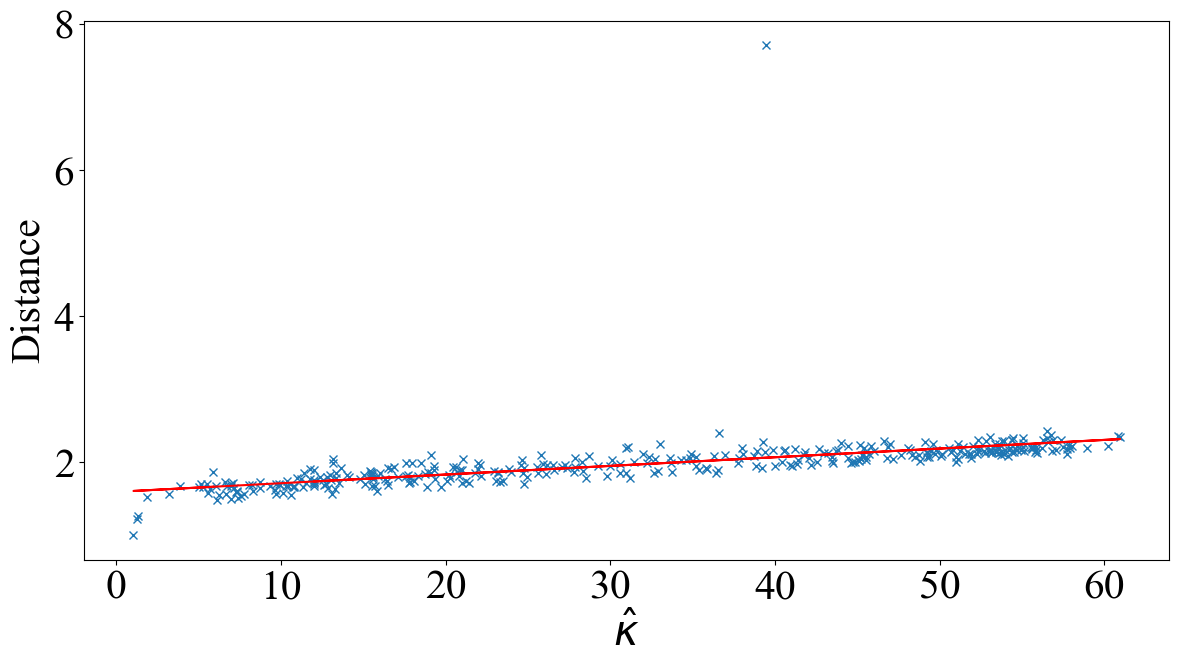

In [195]:
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

distance_hat = res.fittedvalues
plt.plot(kappa_distance_2022["kappa"], kappa_distance_2022["distance"], "x", label="2022")
plt.plot(kappa_distance_2022["kappa"], distance_hat, "r")


plt.xlabel(r"$\hat{\kappa}$", fontsize=30)
plt.ylabel("Distance", fontsize=30)
plt.tick_params(labelsize=30)
# plt.legend(prop={"size": 40}, loc="lower right")
plt.savefig("../fig/cssj/kappa_distance_2022.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

In [196]:
kappa_2023 = []
alpha = 0.119
beta = 7.9

for i in range(len(edge_2023)):
    kappa_2023.append(kappa(edge_2023[i], Np))

# 距離
# df_2022のインデックスをstarted_atにする
df_2023.index = df_2023["started_at"]
distance_2023 = df_2023["distance"].resample("D").mean()

# 距離とkappaの回帰分析
kappa_distance_2023 = pd.DataFrame({"kappa": kappa_2023, "distance": distance_2023})

# olsを使用して分析を行う
formula = "distance ~ kappa"
res = smf.ols(formula, data=kappa_distance_2023).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     784.9
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           5.22e-82
Time:                        11:21:03   Log-Likelihood:                 188.06
No. Observations:                 273   AIC:                            -372.1
Df Residuals:                     271   BIC:                            -364.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5175      0.019     81.800      0.0

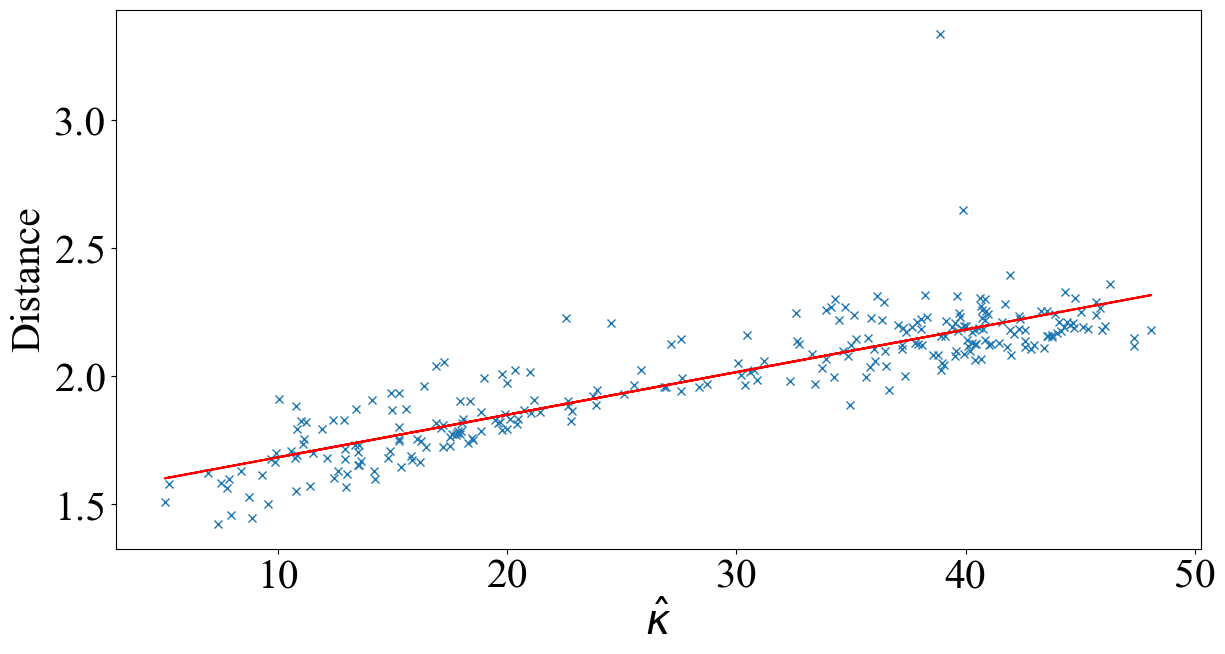

In [198]:
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

distance_hat = res.fittedvalues
plt.plot(kappa_distance_2023["kappa"], kappa_distance_2023["distance"], "x", label="2023")
plt.plot(kappa_distance_2023["kappa"], distance_hat, "r")


plt.xlabel(r"$\hat{\kappa}$", fontsize=30)
plt.ylabel("Distance", fontsize=30)
plt.tick_params(labelsize=30)
# plt.legend(prop={"size": 40}, loc="lower right")
plt.savefig("../fig/cssj/kappa_distance_2023.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

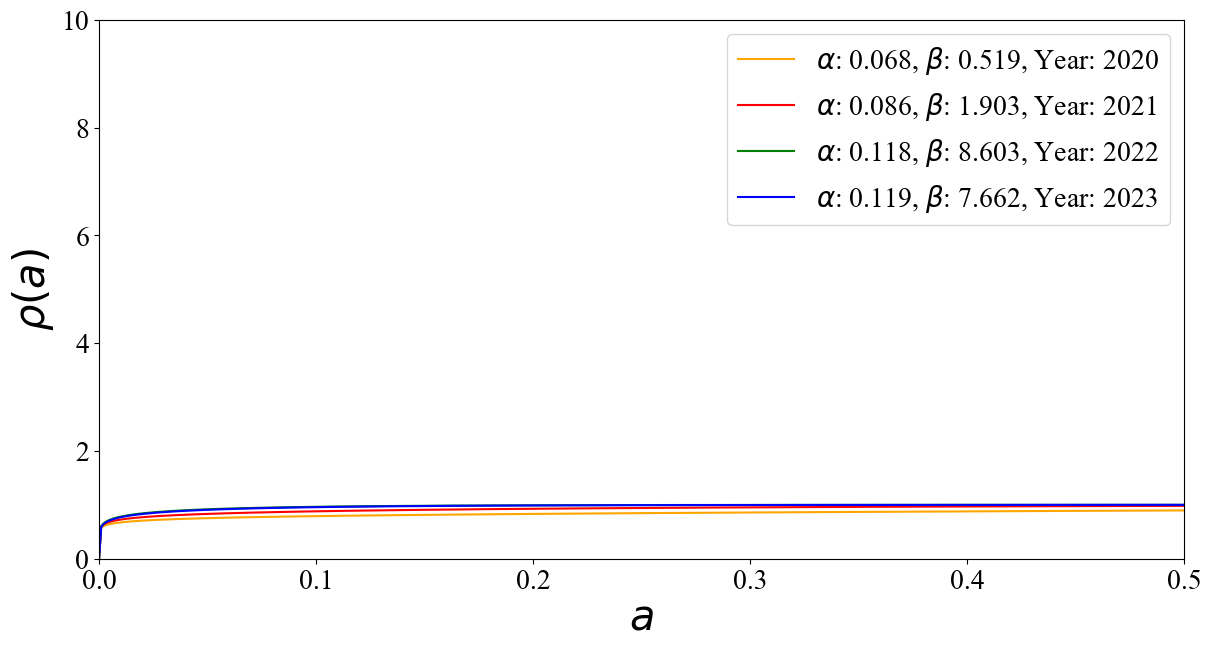

In [145]:
# beta分布からaをサンプリングする
a = np.linspace(0, 1, 1001)
alpha_list = [0.068, 0.086, 0.118, 0.119]
beta_list = [0.519, 1.903, 8.603, 7.662]
label_list = ['Year: 2020', 'Year: 2021', 'Year: 2022', 'Year: 2023']

plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

"""
for i in range(len(alpha_list)):
    # log-log plot
    y = stats.beta.pdf(a, alpha_list[i], beta_list[i])
    plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[i], beta_list[i], label_list[i]))
"""

y = stats.beta.cdf(a, alpha_list[0], beta_list[0])
plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[0], beta_list[0], label_list[0]), c="orange")

y = stats.beta.cdf(a, alpha_list[1], beta_list[1])
plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[1], beta_list[1], label_list[1]), c="red")

y = stats.beta.cdf(a, alpha_list[2], beta_list[2])
plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[2], beta_list[2], label_list[2]), c="green")

y = stats.beta.cdf(a, alpha_list[3], beta_list[3])
plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[3], beta_list[3], label_list[3]), c="blue")

plt.xlabel(f"$a$", fontsize=30, fontname="Times New Roman")
plt.ylabel(f"$\\rho(a)$", fontsize=30, fontname="Times New Roman")

plt.xlim(0, 0.5)
plt.ylim(0, 10)

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.savefig("../fig/cssj/cdf.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

In [122]:
# subsample at 2020
subalpha_list = [0.088, 0.085, 0.085, 0.094]
subbeta_list = [1.451, 5.735, 1.626, 3.621]

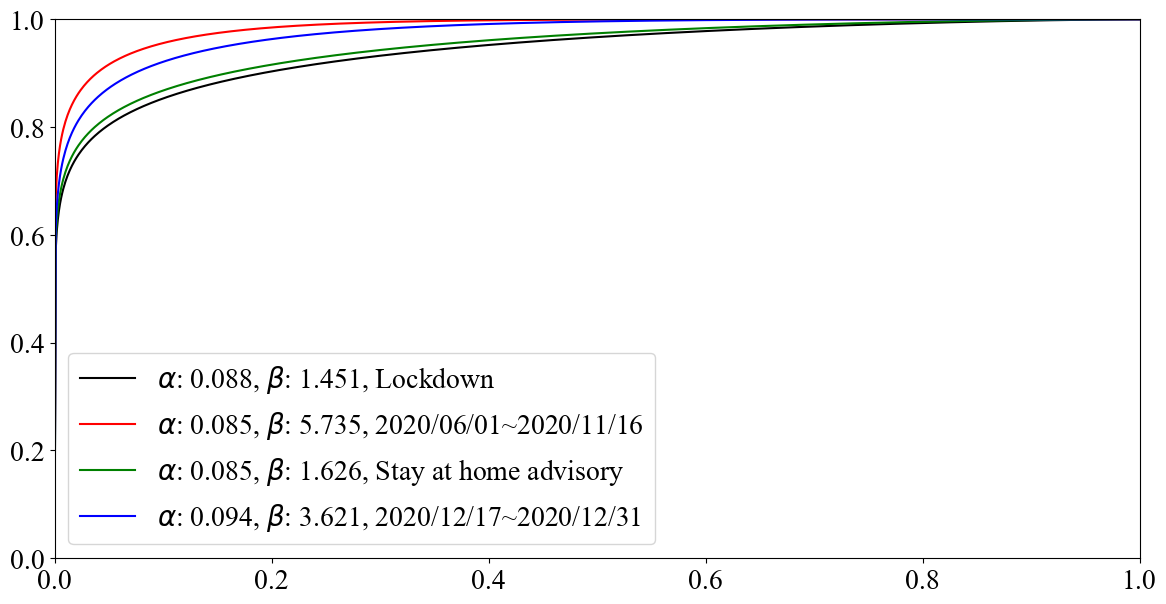

In [144]:
# beta分布からaをサンプリングする
a = np.linspace(0, 1, 1001)
alpha_list = [0.086, 0.118, 0.119]
beta_list = [1.903, 8.603, 7.662]
sublabel = ['Lockdown', '2020/06/01~2020/11/16', 'Stay at home advisory', '2020/12/17~2020/12/31']
label_list = ['Year: 2021', 'Year: 2022', 'Year: 2023']

plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

"""
for i in range(len(alpha_list)):
    # log-log plot
    y = stats.beta.pdf(a, alpha_list[i], beta_list[i])
    plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[i], beta_list[i], label_list[i]))
"""

y = stats.beta.cdf(a, subalpha_list[0], subbeta_list[0])
plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(subalpha_list[0], subbeta_list[0], sublabel[0]), c="black")


y = stats.beta.cdf(a, subalpha_list[1], subbeta_list[1])
plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(subalpha_list[1], subbeta_list[1], sublabel[1]), c="red")

y = stats.beta.cdf(a, subalpha_list[2], subbeta_list[2])
plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(subalpha_list[2], subbeta_list[2], sublabel[2]), c="green")

y = stats.beta.cdf(a, subalpha_list[3], subbeta_list[3])
plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(subalpha_list[3], subbeta_list[3], sublabel[3]), c="blue")
""" 
y = stats.beta.cdf(a, alpha_list[0], beta_list[0])
plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[0], beta_list[0], label_list[0]), c="orange")

y = stats.beta.cdf(a, alpha_list[1], beta_list[1])
plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[1], beta_list[1], label_list[1]), c="red")

y = stats.beta.cdf(a, alpha_list[2], beta_list[2])
plt.plot(a, y, label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[2], beta_list[2], label_list[2]), c="green")
"""
# plt.xlabel(f"$a_i$", fontsize=30, fontname="Times New Roman")
# plt.ylabel(f"$CDF$", fontsize=30, fontname="Times New Roman")

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.savefig("../fig/cssj/cdf_sub.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()